## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Exploratory data analysis

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#observe the different feature type present in the data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

Here we will observe the distribution of our classes

In [4]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

In [5]:
classes

0    284315
1       492
Name: Class, dtype: int64

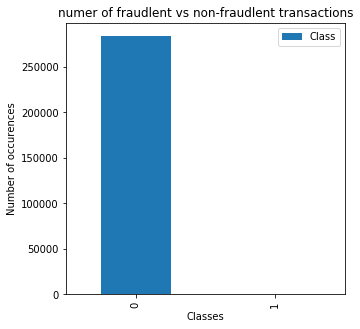

In [6]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
classes.plot(figsize=(5,5),kind='bar',title='numer of fraudlent vs non-fraudlent transactions',legend='True')
plt.xlabel("Classes")
plt.ylabel("Number of occurences")
plt.show()

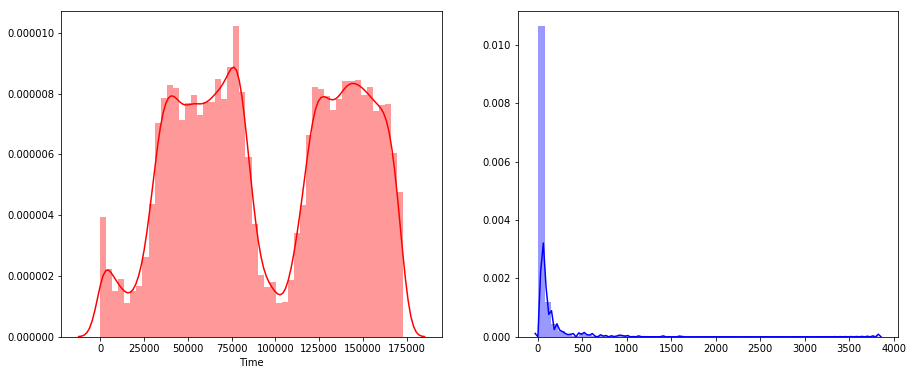

In [7]:
#Check the dsitribution of time and amount features
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.distplot(df['Time'],color='red')
plt.subplot(1,2,2)
sns.distplot(sorted(df['Amount'][0:1000]),color='blue')
plt.show()

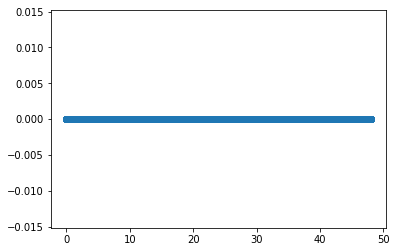

In [8]:
plt.scatter(df.loc[df['Class']==0]['Time']/3600,df.loc[df['Class']==0]['Class'])
plt.show()

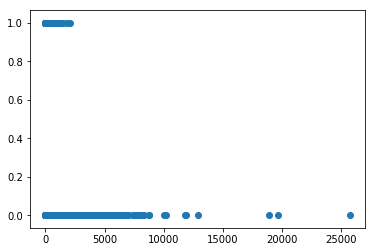

In [9]:
# Create a scatter plot to observe the distribution of classes with Amount
plt.scatter(df['Amount'],df['Class'])
plt.show()

In [4]:
# Drop unnecessary columns
df=df.drop(['Time','Amount'],axis=1)

### Splitting the data into train & test data

In [5]:
y= df.pop('Class')#class variable

In [6]:
x=df

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, train_size=0.7, test_size=0.3, random_state=100)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [14]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
350
142


### Plotting the distribution of a variable

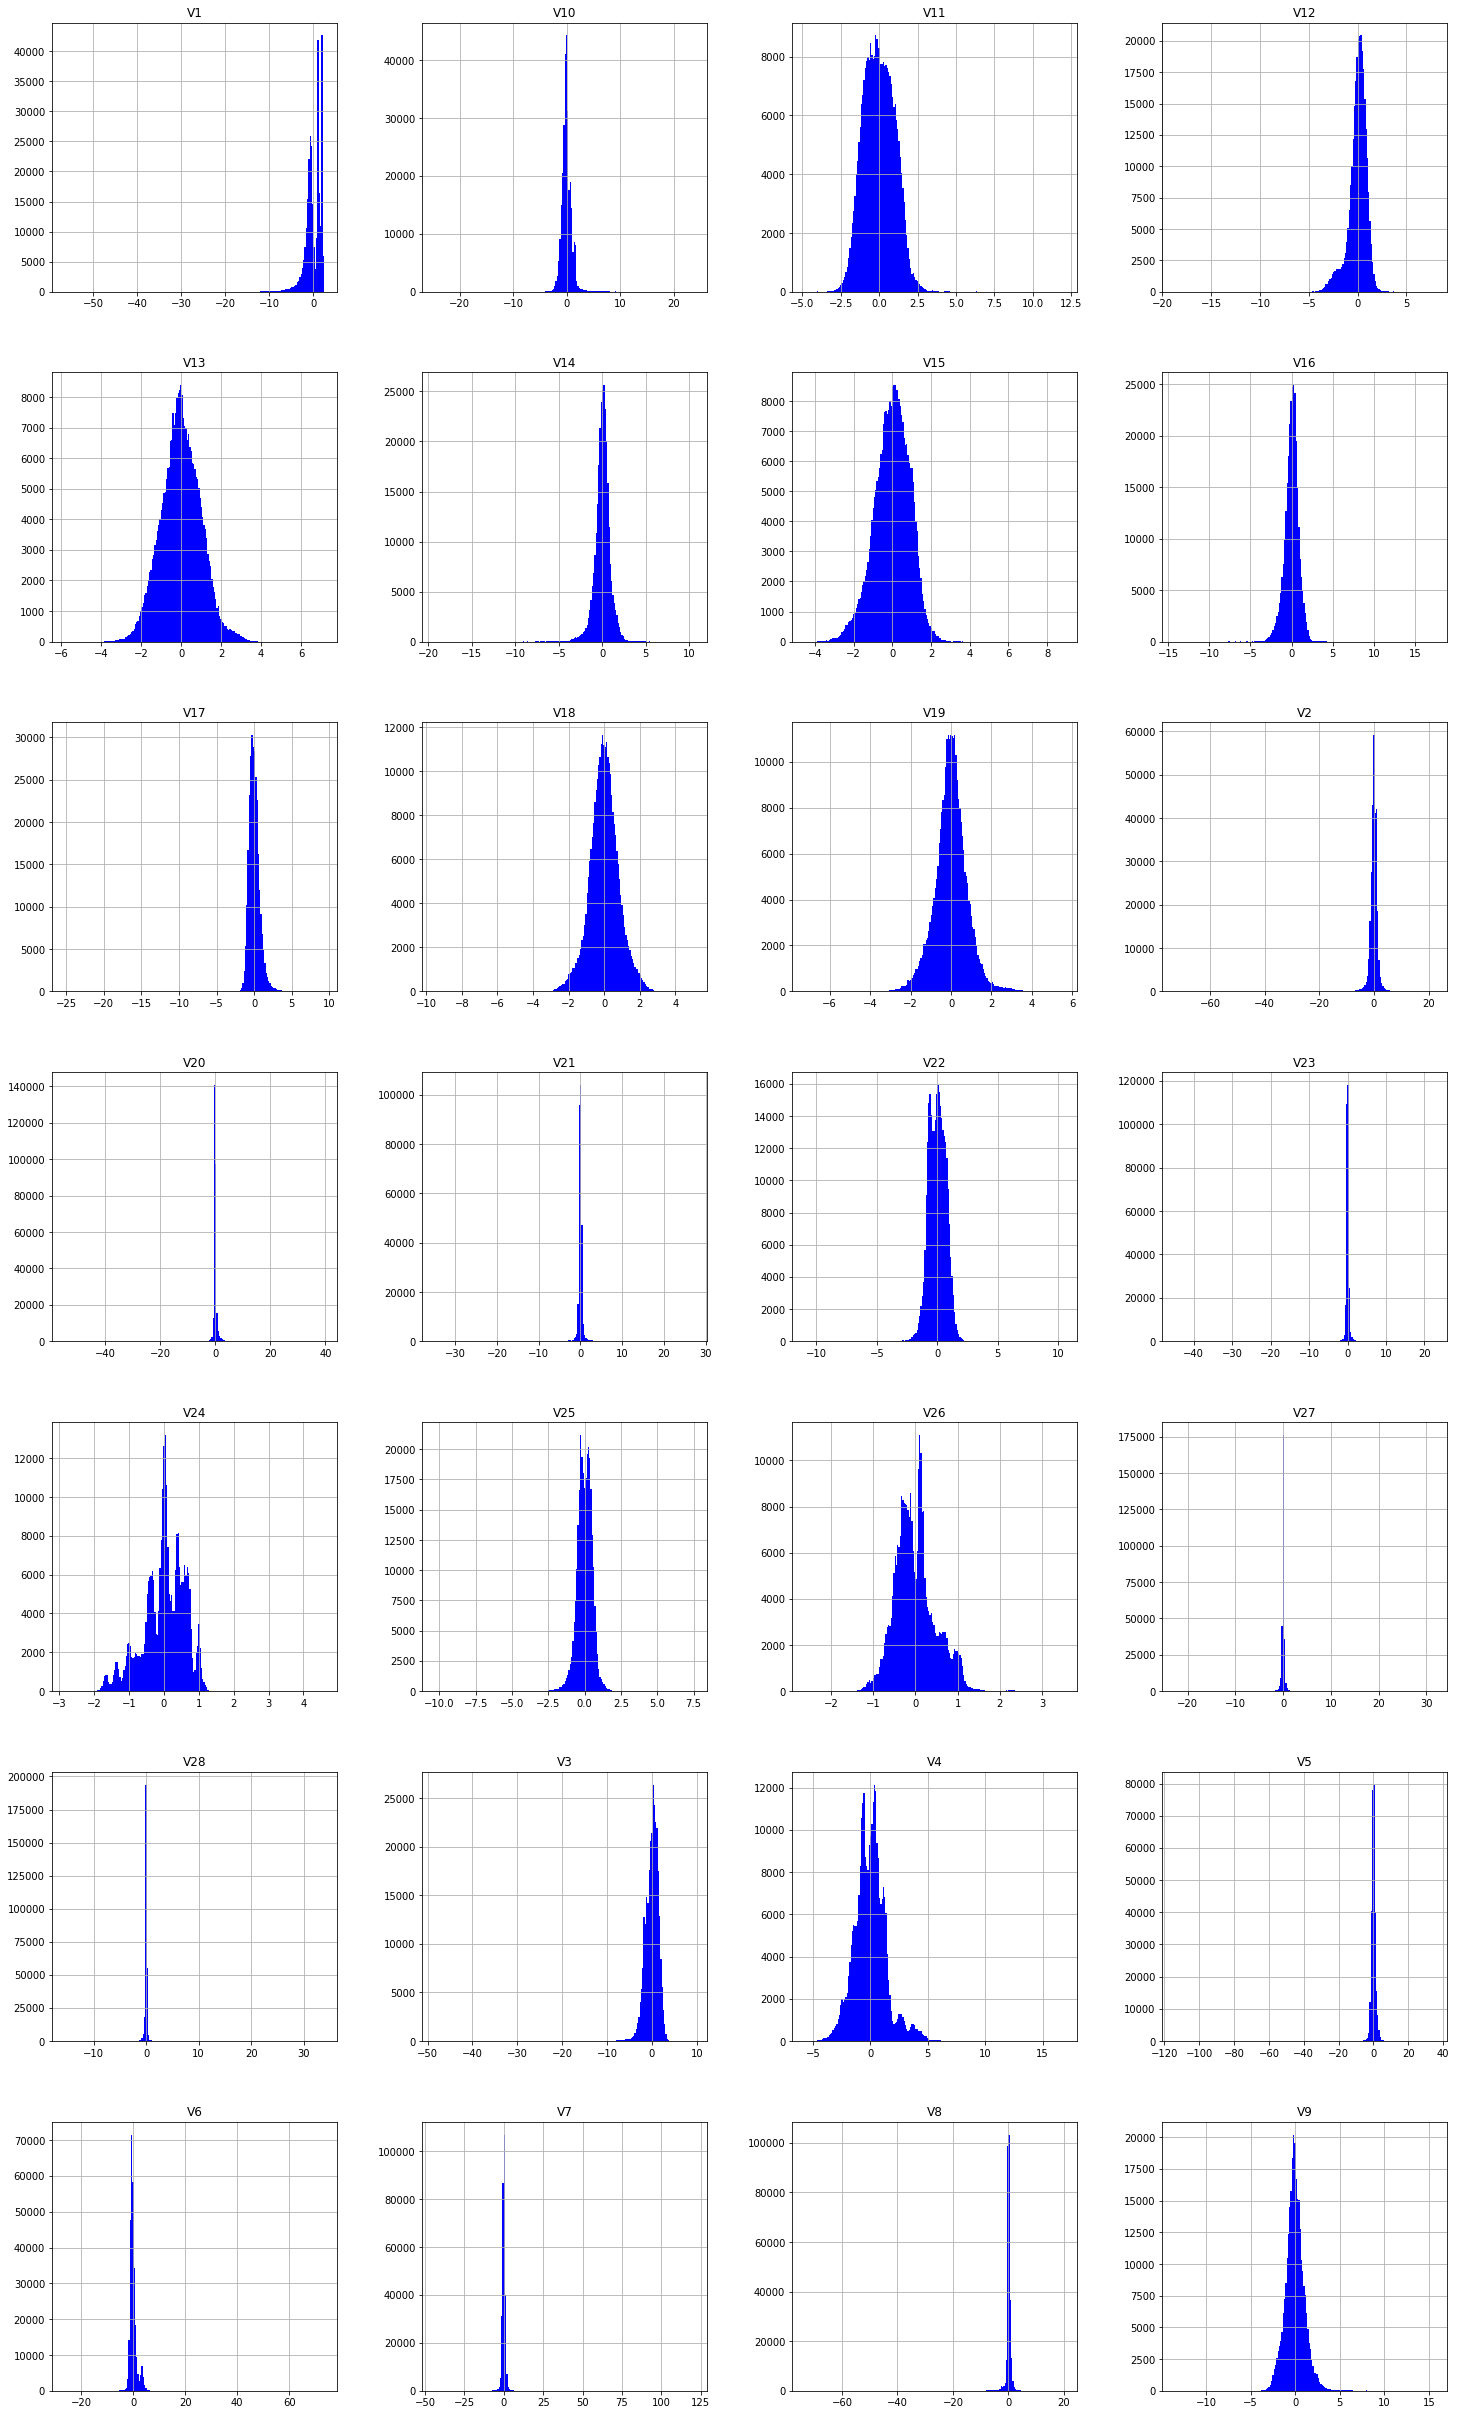

In [15]:
# plot the histogram of a variables from the dataset to see the skewness

df.hist(bins=200,color='blue',figsize=(25,50),layout=(8,4))
plt.show()

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [8]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method='yeo-johnson', standardize=True)
X_train = power.fit_transform(X_train)
X_test = power.fit_transform(X_test)

In [9]:
columns1=x.columns

In [10]:
X_train=pd.DataFrame(X_train,columns=columns1)

In [11]:
X_test=pd.DataFrame(X_test,columns=columns1)

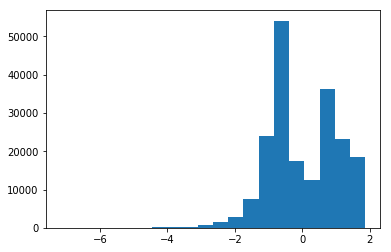

In [20]:
# plot the histogram of a variable from the dataset again to see the result 
plt.hist(X_train['V1'],bins=20)
plt.show()

# Creating Some functions before Modelling to optimize the Code

### 1. Funtion for ROC/AUC Curve

In [21]:

def roc_curve_auc(classifier, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    #TEST DATA ROC
    
    #Using probability scores to compute the ROC
    class_probabilities = classifier.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    fpr["Test"], tpr["Test"], threshold = roc_curve(y_test, y_probs)
    roc_auc["Test"] = auc(fpr["Test"], tpr["Test"])
    
    #TRAIN DATA ROC
    
    #Using probability scores to compute the ROC
    class_probabilities = classifier.predict_proba(X_train)
    y_probs = class_probabilities[:,1]
    fpr["Train"], tpr["Train"], threshold = roc_curve(y_train, y_probs)
    roc_auc["Train"] = auc(fpr["Train"], tpr["Train"])
    
    plt.figure(figsize=(15,10))
    linewidth = 2
    plt.plot(fpr["Test"], tpr["Test"], color='green', lw=linewidth, label='ROC curve Test Data (area = %0.2f)' % roc_auc["Test"])
    plt.plot(fpr["Train"], tpr["Train"], color='red', lw=linewidth, label='ROC curve Train Data (area = %0.2f)' % roc_auc["Train"])
    plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--', label='Baseline ROC curve (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### 2. Function to print metrics

In [22]:
def model_metrics(rsearch_cv, X_train, y_train, X_test, y_test, class_labels):
    
    #To store results at various phases during training as well as cross validation stages
    results = dict()
    model = rsearch_cv.best_estimator_
    
    
    #Predicting the test data

    y_pred = model.predict(X_test)
    results['Predicted'] = y_pred
   

    #F1 score 
    f1_score = metrics.f1_score(y_true=y_test, y_pred=y_pred, average='micro')
    results['F1_Score'] = f1_score
    print("F1 Score = ",f1_score)      
    

    #Overall accuracy
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    results['Accuracy'] = accuracy
    print("Accuracy = ",accuracy)
    
    #Overall recall_score
    recall = metrics.recall_score(y_true=y_test, y_pred=y_pred)
    results['Recall'] = recall
    print("Recall = ", recall)
    
    #Overall roc-auc of the model
    #Calibrate the model
    sig_clf = CalibratedClassifierCV(model, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    class_probabilities = sig_clf.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=y_probs)
    results['ROC-AUC'] = roc_auc
    print("ROC = ",roc_auc)   
                   
    #Display the classification report having individual class recalls and precision values.
    classification_report = metrics.classification_report(y_test, y_pred)
    results['Classification_Report'] = classification_report
    print("Classification report")
    print(classification_report)
    
    #Add the trained  model to the results
    results['Model'] = model
    
    #confusion matrix
    print("Confusion_matrix")
    print(confusion_matrix(y_test, y_pred))
    
    return results, model

### 3. Function to print the Best Parameters

In [23]:
def grid_search(model):
    print("Best Estomators =",model.best_estimator_)
    print("Best Params =",model.best_params_)
    print("Best No of CrossValidation sets =",model.n_splits_)
    print("Best Score =",model.best_score_)

In [24]:
state=48

## Model Building
- Build different models on the imbalanced dataset and see the result

### 1. Logistic Regression Classifier

In [27]:
# Logistic Regression
from sklearn import linear_model #import the package

num_C = np.logspace(0, 4, 10)  #--> list of values
cv_num = 5  #--> list of values
penalty = ['l1', 'l2']
hyperparameters = dict(C=num_C, penalty=penalty)

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

In [28]:
#perform cross validation
#perform hyperparameter tuning
#print the evaluation result by choosing a evaluation metric
#print the optimum value of hyperparameters

from sklearn.model_selection import GridSearchCV
logistic = linear_model.LogisticRegression()
logistic_cv=GridSearchCV(logistic, hyperparameters, cv=cv_num,scoring= 'roc_auc',return_train_score=True, verbose=0)
logistic_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             

In [29]:
cv_results = pd.DataFrame(logistic_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.053068,0.007748,0.000000,0.000000,1,l1,"{'C': 1.0, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.577179,0.100930,0.041489,0.018134,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.990447,0.977734,0.974185,...,0.982205,0.007126,1,0.983435,0.985093,0.984731,0.982174,0.985563,0.984199,0.001235
2,0.047877,0.001669,0.000000,0.000000,2.78256,l1,"{'C': 2.7825594022071245, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.609506,0.139750,0.026523,0.001016,2.78256,l2,"{'C': 2.7825594022071245, 'penalty': 'l2'}",0.990423,0.977672,0.974095,...,0.982130,0.007153,2,0.983356,0.985006,0.984647,0.982098,0.985505,0.984122,0.001237
4,0.060439,0.003191,0.000000,0.000000,7.74264,l1,"{'C': 7.742636826811269, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Best Parameters
grid_search(logistic_cv)

Best Estomators = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Params = {'C': 1.0, 'penalty': 'l2'}
Best No of CrossValidation sets = 5
Best Score = 0.9822046024177095


In [33]:
from sklearn.calibration import CalibratedClassifierCV
log_reg_grid_results, trained_model =  model_metrics(logistic_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

F1 Score =  0.9991807403766253
Accuracy =  0.9991807403766253
Recall =  0.6549295774647887
ROC =  0.9672730584041169
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.82      0.65      0.73       142

    accuracy                           1.00     85443
   macro avg       0.91      0.83      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Confusion_matrix
[[85280    21]
 [   49    93]]


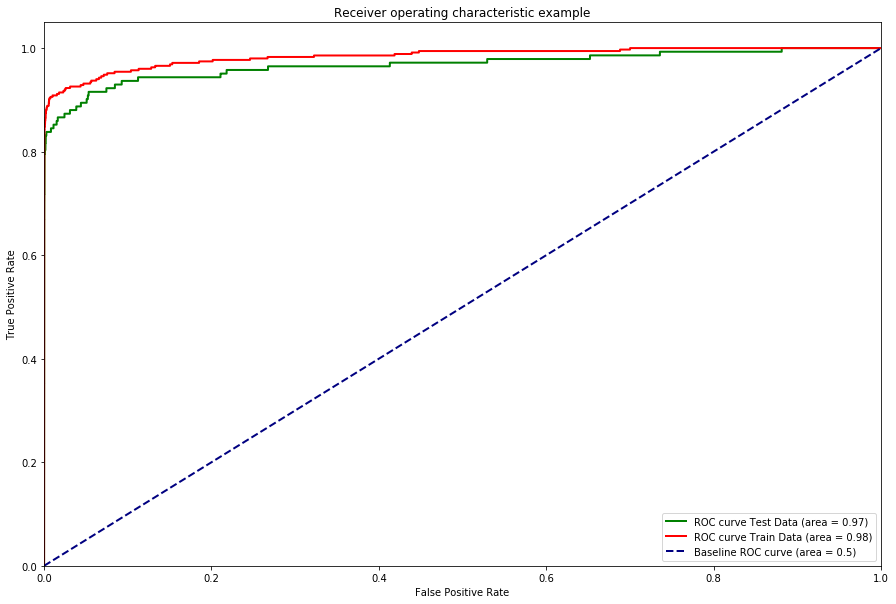

In [34]:
#Calibrate the model

sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#ROC curve
roc_curve_auc(sig_clf, X_train, y_train, X_test, y_test)

### 2. KNN Classifier

In [48]:
from sklearn.neighbors import KNeighborsClassifier

grid_params = {'n_neighbors': [3],
                    'weights': ['uniform'],
                    'metric': ['euclidean'] }

knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, grid_params ,
                      cv=3,scoring= 'roc_auc',
                      return_train_score=True, 
                      verbose=5,n_jobs=-1)

knn_cv.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 27.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 27.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['euclidean'], 'n_neighbors': [3],
                         'weights': ['uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

In [49]:
cv_results = pd.DataFrame(knn_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.66647,0.034039,576.065792,12.093539,euclidean,3,uniform,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.927214,0.905902,0.9223,0.918472,0.009112,1,0.999944,0.999948,0.999945,0.999945,0.000002


In [50]:
# Best Parameters
grid_search(knn_cv)

Best Estomators = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Best Params = {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best No of CrossValidation sets = 3
Best Score = 0.9184718060569109


### 3. Decision Trees Classifier

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

grid_params = {'max_depth': np.arange(1,10,1),
                    'criterion': ['gini'],
                    'min_samples_split': np.arange(1000,10000,1000),
                    'min_samples_leaf' : np.arange(1000,10000,1000),
                    'min_weight_fraction_leaf' : [0.0,0.1,0.2,0.3,0.4],
                    'max_features': ['auto','sqrt']} 

dtree = DecisionTreeClassifier(random_state=state)
dtree_cv = GridSearchCV(dtree,
                        grid_params,
                        cv=3, scoring='roc_auc',
                        verbose=5,
                        n_jobs=-1,)

dtree_cv.fit(X_train, y_train)

Fitting 3 folds for each of 7290 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=48,
                                              splitter='best'),
             iid='depr...
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                        

In [32]:
cv_results = pd.DataFrame(dtree_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_min_weight_fraction_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.870018,0.249357,0.128659,0.025245,gini,1,auto,1000,1000,0,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.796146,0.800283,0.832687,0.809705,0.016338,5815
1,0.734048,0.090170,0.124004,0.021395,gini,1,auto,1000,1000,0.1,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.883567,0.877258,0.885434,0.882086,0.003498,2415
2,0.791229,0.173637,0.114363,0.036349,gini,1,auto,1000,1000,0.2,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.858370,0.843967,0.849411,0.850582,0.005938,4069
3,0.576800,0.011526,0.090426,0.021256,gini,1,auto,1000,1000,0.3,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.825259,0.823676,0.799568,0.816168,0.011756,4357
4,0.648941,0.010627,0.072474,0.001695,gini,1,auto,1000,1000,0.4,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.786337,0.785892,0.763010,0.778413,0.010893,5833


In [33]:
# Best Parameters
grid_search(dtree_cv)

Best Estomators = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1000, min_samples_split=4000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=48, splitter='best')
Best Params = {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1000, 'min_samples_split': 4000, 'min_weight_fraction_leaf': 0.0}
Best No of CrossValidation sets = 3
Best Score = 0.9524735056857127


In [36]:
log_reg_grid_results, trained_model_dtree =  model_metrics(dtree_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

F1 Score =  0.99833807333544
Accuracy =  0.99833807333544
Recall =  0.0
ROC =  0.9399819215170271
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.00      0.00      0.00       142

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Confusion_matrix
[[85301     0]
 [  142     0]]


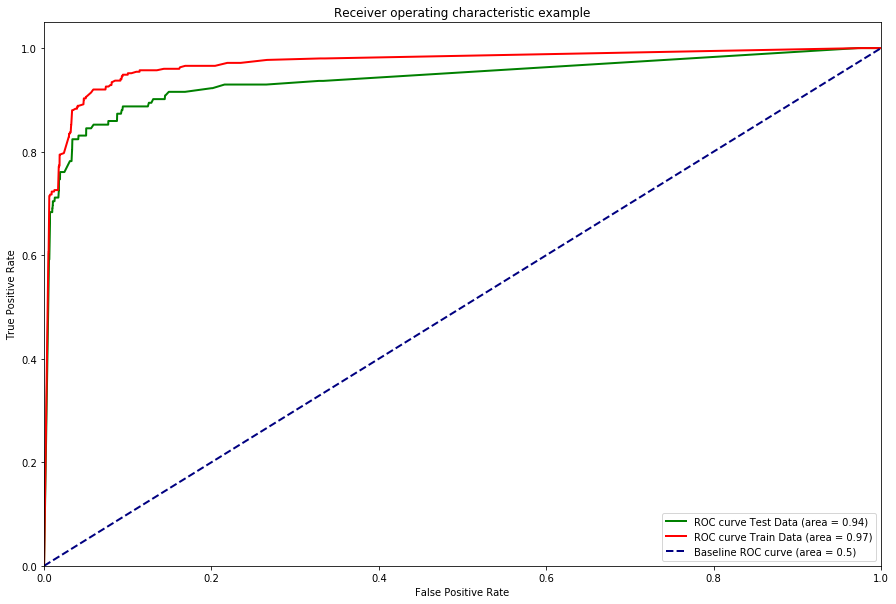

In [37]:
#Calibrate the model

sig_clf_dtree = CalibratedClassifierCV(trained_model_dtree, method="sigmoid")
sig_clf_dtree.fit(X_train, y_train)

#ROC curve
roc_curve_auc(sig_clf_dtree, X_train, y_train, X_test, y_test)

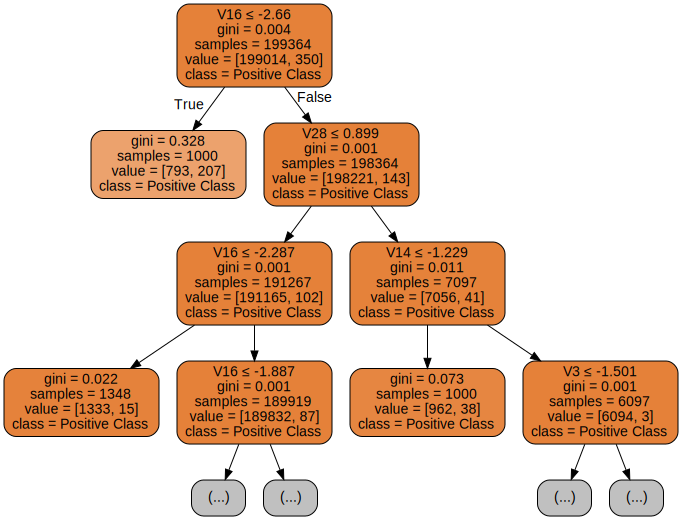

In [38]:
#https://scikit-learn.org/stable/modules/tree.html
def visualize_tree(trained_clf, f_names, filename):
    from sklearn import tree
    import graphviz
    dot_data = tree.export_graphviz(decision_tree=trained_clf, out_file=None, max_depth=3, filled=True, rounded=True, special_characters=True, impurity=True, feature_names=f_names, class_names=['Positive Class','Negative Class'])  
    graph = graphviz.Source(dot_data)  
    graph.render(filename, format='png') 
    return graph

#Call the function above and pass a filename onto it.
f_names=[i for i in X_train.columns]

graph=visualize_tree(trained_model_dtree, f_names, 'Credit_Card_Tree.png')
graph

### 4. Random Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

grid_params = {
               'max_depth':[8],
               'criterion':['entropy'],
               'max_features':['auto'],
               'min_samples_leaf':[10,20,30],
               'n_estimators':[30],
               'max_leaf_nodes':[None, 10]}

rfc = RandomForestClassifier(random_state=5)
rfc_cv = GridSearchCV(rfc,
                      grid_params, 
                      cv=3, scoring='roc_auc',
                      verbose=5,
                      n_jobs=-1)

rfc_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:  1.2min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:  1.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  2.0min remaining:   24.4s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=5,
                                   

In [36]:
cv_results = pd.DataFrame(rfc_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,70.285981,1.638658,0.579119,0.020233,entropy,8,auto,None,10,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.981918,0.966453,0.982433,0.976935,0.007415,1
1,61.394199,0.694666,0.541553,0.061583,entropy,8,auto,None,20,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.972764,0.964341,0.980190,0.972432,0.006475,2
2,62.574863,3.766088,0.522936,0.100879,entropy,8,auto,None,30,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.977089,0.962446,0.971911,0.970482,0.006063,5
3,42.854003,1.893672,0.408907,0.031738,entropy,8,auto,10,10,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.974628,0.953052,0.976213,0.967964,0.010565,6
4,49.352771,0.232119,0.321783,0.041172,entropy,8,auto,10,20,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.981389,0.955239,0.979504,0.972044,0.011908,3


In [37]:
# Best Parameters
grid_search(rfc_cv)

Best Estomators = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)
Best Params = {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'n_estimators': 30}
Best No of CrossValidation sets = 3
Best Score = 0.9769347348609013


In [38]:
log_reg_grid_results, trained_model_rfc =  model_metrics(rfc_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

F1 Score =  0.9993445923013002
Accuracy =  0.9993445923013002
Recall =  0.7394366197183099
ROC =  0.9761637786060333
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.85      0.74      0.79       142

    accuracy                           1.00     85443
   macro avg       0.92      0.87      0.89     85443
weighted avg       1.00      1.00      1.00     85443

Confusion_matrix
[[85282    19]
 [   37   105]]


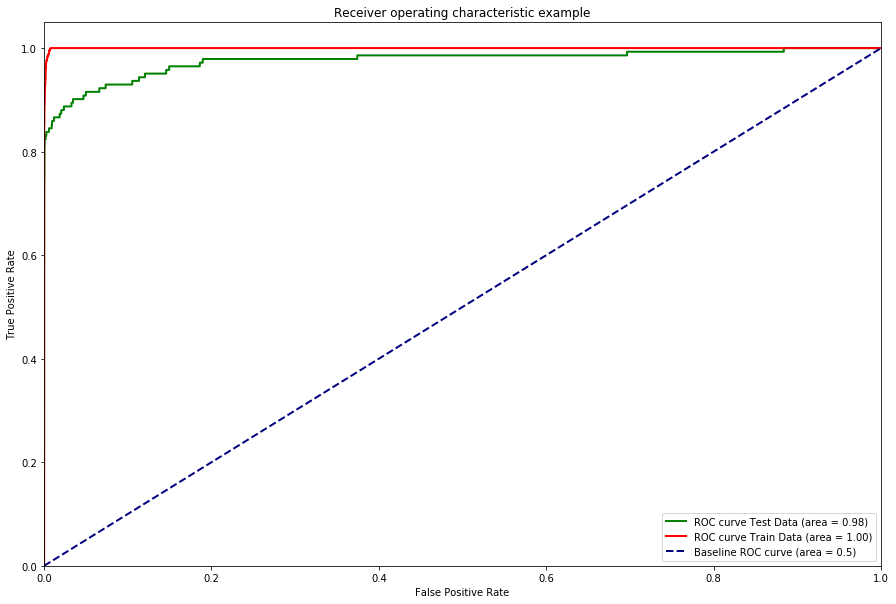

In [39]:
#Calibrate the model

sig_clf_rfc = CalibratedClassifierCV(trained_model_rfc, method="sigmoid")
sig_clf_rfc.fit(X_train, y_train)

#ROC curve
roc_curve_auc(sig_clf_rfc, X_train, y_train, X_test, y_test)

### 5. XGBoost Classifier

In [42]:
import xgboost
from xgboost import XGBClassifier

grid_params =  {'learning_rate':[0.1,0.01],
                    'n_estimators':[25,50],
                    'subsample':[0.6,0.7,0.8],
                    'max_depth': [11,15,17,20],
                    'colsample_bytree':[0.6,0.8],
                    'gamma':[0,0.25,0.7,1]}

XGB = XGBClassifier(random_state=state)

XGB_cv = GridSearchCV(XGB,grid_params,
                      cv=3, scoring='roc_auc',
                      verbose=5,
                      n_jobs=-1)
XGB_cv.fit(X_train, y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 51.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 85.8min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 121.5min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 169.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 172.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8],
                         'gamma':

In [44]:
cv_results = pd.DataFrame(XGB_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,34.015893,2.289281,0.370046,0.068501,0.6,0,0.1,11,25,0.6,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",0.947167,0.909374,0.934586,0.930376,0.015714,185
1,39.154323,3.854773,0.355750,0.022113,0.6,0,0.1,11,25,0.7,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",0.947180,0.913250,0.946535,0.935655,0.015845,97
2,39.193681,2.360591,0.387329,0.055026,0.6,0,0.1,11,25,0.8,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",0.947262,0.909495,0.941884,0.932880,0.016681,145
3,77.177058,9.829962,0.733755,0.260875,0.6,0,0.1,11,50,0.6,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",0.966782,0.956149,0.969820,0.964250,0.005861,24
4,80.999682,6.856541,0.480747,0.034463,0.6,0,0.1,11,50,0.7,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",0.971084,0.954977,0.968353,0.964805,0.007038,1


In [45]:
# Best Parameters
grid_search(XGB_cv)

Best Estomators = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=48, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best Params = {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 50, 'subsample': 0.7}
Best No of CrossValidation sets = 3
Best Score = 0.96480482683994


In [46]:
log_reg_grid_results, trained_model_XGB =  model_metrics(XGB_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

F1 Score =  0.9994265182636377
Accuracy =  0.9994265182636377
Recall =  0.7394366197183099
ROC =  0.9552632673923046
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.90      0.74      0.81       142

    accuracy                           1.00     85443
   macro avg       0.95      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Confusion_matrix
[[85289    12]
 [   37   105]]


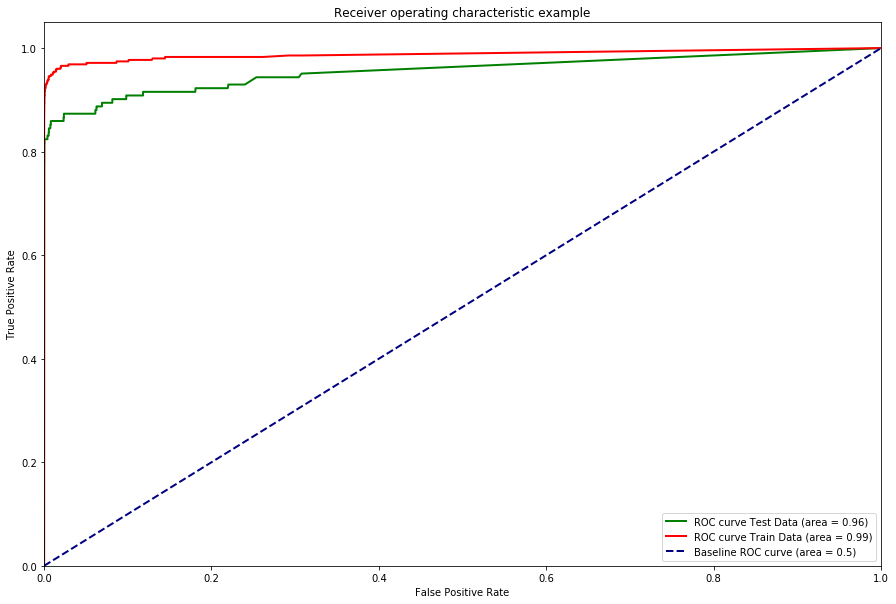

In [47]:
#Calibrate the model

sig_clf_XGB = CalibratedClassifierCV(trained_model_XGB, method="sigmoid")
sig_clf_XGB.fit(X_train, y_train)

#ROC curve
roc_curve_auc(sig_clf_XGB, X_train, y_train, X_test, y_test)

#### Proceed with the model which shows the best result 
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [19]:
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)  #initialise the model with optimum hyperparameters
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [20]:
#print --> #print the evaluation score on the X_test by choosing the best evaluation metric
y_predicted = clf.predict(X_test)


In [25]:
y_predicted1=pd.Series(y_predicted)

In [27]:
cm = metrics.confusion_matrix(y_test, y_predicted1 )

In [32]:
cm

array([[85282,    19],
       [   37,   105]], dtype=int64)

In [42]:
recall=cm[1][1]/(cm[1][1]+cm[1][0])
recall

0.7394366197183099

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

Top var = 17
2nd Top var = 14
3rd Top var = 10


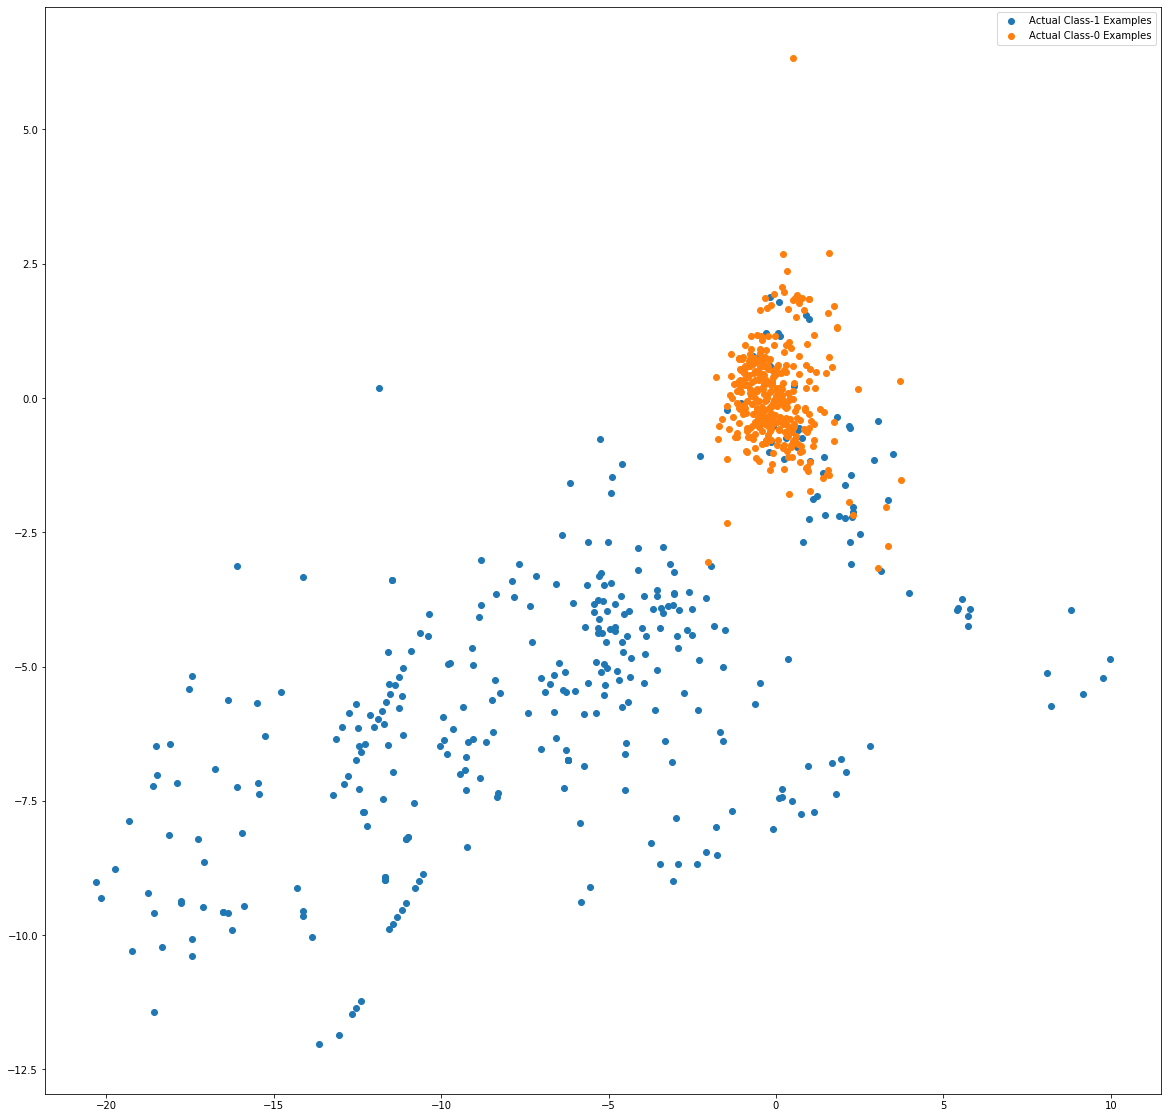

In [78]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

#### 1. Random OverSampling

In [15]:
from imblearn import over_sampling #- import the packages
from imblearn.over_sampling import RandomOverSampler
print('class 1 data count in actual data',y_train.value_counts()[1])
print('class 0 data count in actual data',y_train.value_counts()[0])
#random oversampling
rs = RandomOverSampler(random_state=42)
X_train_rs, y_train_rs = rs.fit_resample(X_train, y_train)
print('class 1 data count after random oversampling',y_train_rs.value_counts()[1])
print('class 0 data count after random oversampling',y_train_rs.value_counts()[0])

Using TensorFlow backend.


class 1 data count in actual data 350
class 0 data count in actual data 199014
class 1 data count after random oversampling 199014
class 0 data count after random oversampling 199014


## Model Building
- Build different models on the balanced dataset and see the result

In [16]:
# Logistic Regression
from sklearn import linear_model #import the package

num_C = np.logspace(0, 4, 10)  #--> list of values
cv_num = 5  #--> list of values
penalty = ['l1', 'l2']
hyperparameters = dict(C=num_C, penalty=penalty)

In [17]:
from sklearn.model_selection import GridSearchCV
logistic = linear_model.LogisticRegression()
logistic_cv=GridSearchCV(logistic, hyperparameters, cv=cv_num,scoring= 'roc_auc',return_train_score=True, verbose=0)
logistic_cv.fit(X_train_rs,y_train_rs)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             

In [18]:
cv_results = pd.DataFrame(logistic_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.106491,0.019803,0.000000,0.000000,1,l1,"{'C': 1.0, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.437741,0.120452,0.063037,0.012573,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.989668,0.989661,0.989887,...,0.989775,0.000179,10,0.989842,0.989803,0.989728,0.989818,0.989807,0.9898,0.000039
2,0.118961,0.015398,0.000000,0.000000,2.78256,l1,"{'C': 2.7825594022071245, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.353704,0.109208,0.049827,0.003350,2.78256,l2,"{'C': 2.7825594022071245, 'penalty': 'l2'}",0.989668,0.989662,0.989887,...,0.989776,0.000179,8,0.989842,0.989803,0.989728,0.989818,0.989807,0.9898,0.000038
4,0.101315,0.007633,0.000000,0.000000,7.74264,l1,"{'C': 7.742636826811269, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Best Parameters
grid_search(logistic_cv)


Best Estomators = LogisticRegression(C=1291.5496650148827, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Params = {'C': 1291.5496650148827, 'penalty': 'l2'}
Best No of CrossValidation sets = 5
Best Score = 0.989775585696998


In [20]:
from sklearn.calibration import CalibratedClassifierCV
log_reg_grid_results, trained_model =  model_metrics(logistic_cv, X_train_rs, y_train_rs, X_test, y_test, class_labels=y_train_rs.values)

F1 Score =  0.9747082850555341
Accuracy =  0.9747082850555341
Recall =  0.9014084507042254
ROC =  0.9732476345983427
Classification report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85301
           1       0.06      0.90      0.11       142

    accuracy                           0.97     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.97      0.99     85443

Confusion_matrix
[[83154  2147]
 [   14   128]]


In [21]:
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train_rs, y_train_rs)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1291.5496650148827,
                                                         class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='auto',
                                                         n_jobs=None,
                                                         penalty='l2',
                                                         random_state=None,
                                                         solver='lbfgs',
                                                         tol=0.0001, verbose=0,
                               

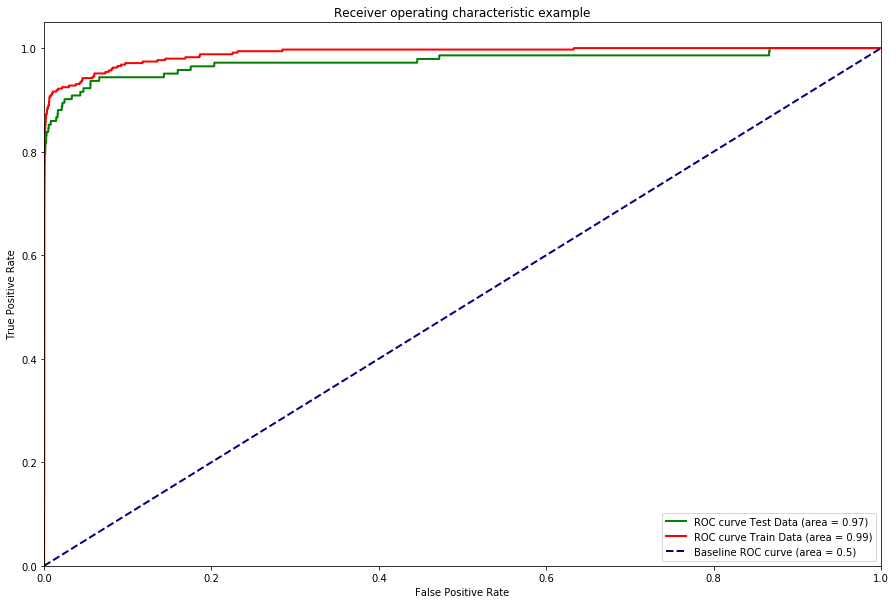

In [22]:
#ROC curve
roc_curve_auc(sig_clf, X_train_rs, y_train_rs, X_test, y_test)

## DecisionTree

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
grid_params = {'max_depth': np.arange(1,10,1),
                    'criterion': ['gini'],
                    'min_samples_split': np.arange(1000,10000,1000),
                    'min_samples_leaf' : np.arange(1000,10000,1000),
                    'min_weight_fraction_leaf' : [0.0,0.1,0.2,0.3,0.4],
                    'max_features': ['auto','sqrt']} 

dtree = DecisionTreeClassifier(random_state=state)
dtree_cv = GridSearchCV(dtree,
                        grid_params,
                        cv=3, scoring='roc_auc',
                        verbose=5,
                        n_jobs=-1,)

dtree_cv.fit(X_train_rs, y_train_rs)

Fitting 3 folds for each of 7290 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 4600 tasks      | ela

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=48,
                                              splitter='best'),
             iid='depr...
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                        

In [25]:
cv_results = pd.DataFrame(dtree_cv.cv_results_)
cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_min_weight_fraction_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.425913,0.074603,0.205484,0.010748,gini,1,auto,1000,1000,0,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.886928,0.884546,0.88539,0.885621,0.000986,3889
1,1.466589,0.705791,0.188624,0.019876,gini,1,auto,1000,1000,0.1,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.886928,0.884546,0.88539,0.885621,0.000986,3889
2,0.970685,0.059295,0.142747,0.007165,gini,1,auto,1000,1000,0.2,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.886928,0.884546,0.88539,0.885621,0.000986,3889
3,0.924700,0.023381,0.137990,0.009560,gini,1,auto,1000,1000,0.3,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.886928,0.884546,0.88539,0.885621,0.000986,3889
4,0.882829,0.036722,0.194146,0.020421,gini,1,auto,1000,1000,0.4,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.886928,0.884546,0.88539,0.885621,0.000986,3889


In [26]:
log_reg_grid_results, trained_model_dtree =  model_metrics(dtree_cv, X_train_rs, y_train_rs, X_test, y_test, class_labels=y_train_rs.values)

F1 Score =  0.9793312500731481
Accuracy =  0.9793312500731481
Recall =  0.8098591549295775
ROC =  0.954526274893001
Classification report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85301
           1       0.06      0.81      0.12       142

    accuracy                           0.98     85443
   macro avg       0.53      0.89      0.55     85443
weighted avg       1.00      0.98      0.99     85443

Confusion_matrix
[[83562  1739]
 [   27   115]]


In [27]:
#Calibrate the model

sig_clf_dtree = CalibratedClassifierCV(trained_model_dtree, method="sigmoid")
sig_clf_dtree.fit(X_train_rs, y_train_rs)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=9,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1000,
                                                             min_samples_split=3000,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
          

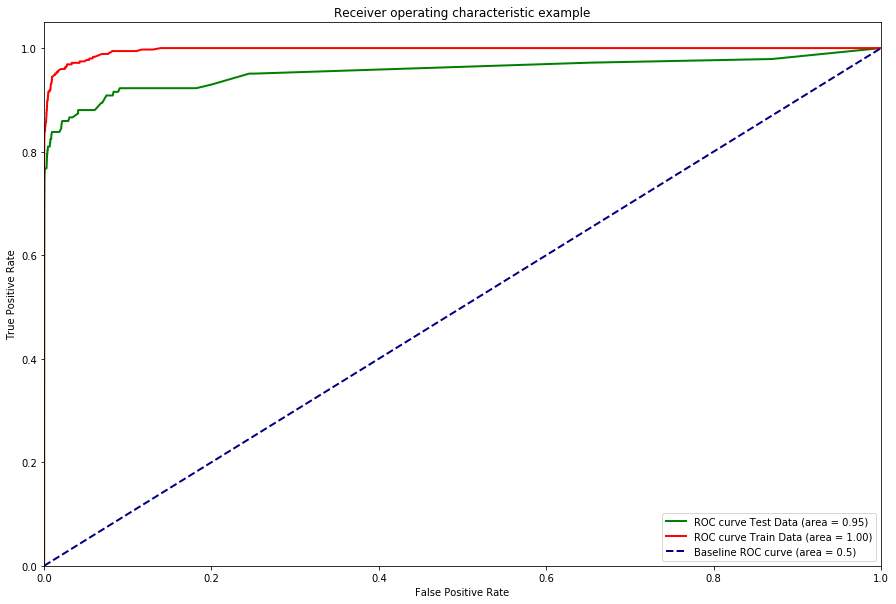

In [28]:
#ROC curve
roc_curve_auc(sig_clf_dtree, X_train_rs, y_train_rs, X_test, y_test)

## RandomForest

In [30]:
from sklearn.ensemble import RandomForestClassifier

grid_params = {
               'max_depth':[8],
               'criterion':['entropy'],
               'max_features':['auto'],
               'min_samples_leaf':[10,20,30],
               'n_estimators':[30],
               'max_leaf_nodes':[None, 10]}

rfc = RandomForestClassifier(random_state=5)
rfc_cv = GridSearchCV(rfc,
                      grid_params, 
                      cv=3, scoring='roc_auc',
                      verbose=5,
                      n_jobs=-1)

rfc_cv.fit(X_train_rs, y_train_rs)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  3.3min remaining:   39.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=5,
                                   

In [31]:
cv_results = pd.DataFrame(rfc_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,53.578656,0.053338,0.839423,0.018735,entropy,8,auto,None,10,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.999838,0.999926,0.999898,0.999887,0.000036,1
1,51.890707,0.746603,0.827124,0.051439,entropy,8,auto,None,20,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.999878,0.999866,0.999904,0.999883,0.000016,2
2,51.610395,0.836591,0.769942,0.001410,entropy,8,auto,None,30,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.999859,0.999857,0.999902,0.999873,0.000021,3
3,41.887047,0.271914,0.638628,0.022747,entropy,8,auto,10,10,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.992748,0.992508,0.992957,0.992738,0.000183,4
4,42.032325,0.233868,0.614026,0.015818,entropy,8,auto,10,20,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.992748,0.992508,0.992957,0.992738,0.000183,4


In [32]:
# Best Parameters
grid_search(rfc_cv)

Best Estomators = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)
Best Params = {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'n_estimators': 30}
Best No of CrossValidation sets = 3
Best Score = 0.9998871784970967


In [33]:
log_reg_grid_results, trained_model_rfc =  model_metrics(rfc_cv, X_train_rs, y_train_rs, X_test, y_test, class_labels=y_train_rs.values)

F1 Score =  0.9985838512224524
Accuracy =  0.9985838512224524
Recall =  0.8028169014084507
ROC =  0.9801155675568752
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.55      0.80      0.65       142

    accuracy                           1.00     85443
   macro avg       0.78      0.90      0.83     85443
weighted avg       1.00      1.00      1.00     85443

Confusion_matrix
[[85208    93]
 [   28   114]]


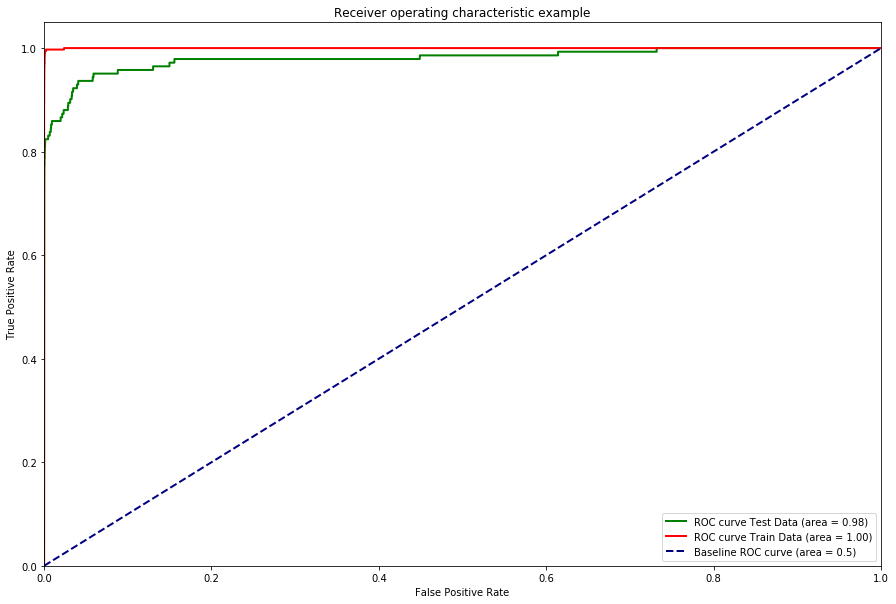

In [34]:
#Calibrate the model

sig_clf_rfc = CalibratedClassifierCV(trained_model_rfc, method="sigmoid")
sig_clf_rfc.fit(X_train_rs, y_train_rs)

#ROC curve
roc_curve_auc(sig_clf_rfc, X_train_rs, y_train_rs, X_test, y_test)

## XGBoost

In [36]:
import xgboost
from xgboost import XGBClassifier

grid_params =  {'learning_rate':[0.1,0.01],
                    'n_estimators':[25,40],
                    'subsample':[0.6,0.8],
                    'max_depth': [11,15,20],
                    'colsample_bytree':[0.6,0.8],
                    'gamma':[0.25,0.7,1]}

XGB = XGBClassifier(random_state=state)

XGB_cv = GridSearchCV(XGB,grid_params,
                      cv=3, scoring='roc_auc',
                      verbose=5,
                      n_jobs=-1)
XGB_cv.fit(X_train_rs, y_train_rs)


Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 116.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 143.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 186.8min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 758.9min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 855.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             

In [37]:
cv_results = pd.DataFrame(XGB_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,84.150755,0.294601,0.733375,0.095744,0.6,0.25,0.1,11,25,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.999881,0.999969,0.999918,0.999923,0.000036,61
1,86.059245,0.925347,0.690155,0.002934,0.6,0.25,0.1,11,25,0.8,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.999882,0.999968,0.999919,0.999923,0.000035,60
2,2331.847159,3126.639444,0.994012,0.081490,0.6,0.25,0.1,11,40,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.999889,0.999993,0.999941,0.999941,0.000043,18
3,6763.825463,2.255755,1.086760,0.062017,0.6,0.25,0.1,11,40,0.8,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.999881,0.999996,0.999943,0.999940,0.000047,21
4,97.025682,0.503702,0.961431,0.192655,0.6,0.25,0.1,15,25,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.999882,0.999970,0.999919,0.999924,0.000036,49


In [38]:
# Best Parameters
grid_search(XGB_cv)

Best Estomators = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.7, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=40, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=48, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best Params = {'colsample_bytree': 0.6, 'gamma': 0.7, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 40, 'subsample': 0.8}
Best No of CrossValidation sets = 3
Best Score = 0.9999472212215273


In [39]:
log_reg_grid_results, trained_model_XGB =  model_metrics(XGB_cv, X_train_rs, y_train_rs, X_test, y_test, class_labels=y_train_rs.values)

F1 Score =  0.9992626663389628
Accuracy =  0.9992626663389628
Recall =  0.795774647887324
ROC =  0.977451141946225
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.77      0.80      0.78       142

    accuracy                           1.00     85443
   macro avg       0.88      0.90      0.89     85443
weighted avg       1.00      1.00      1.00     85443

Confusion_matrix
[[85267    34]
 [   29   113]]


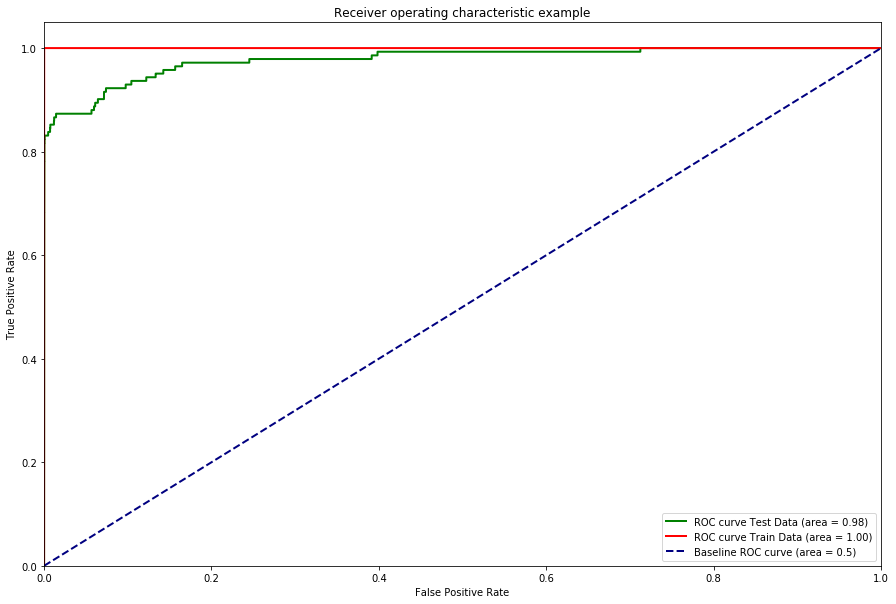

In [40]:
#Calibrate the model

sig_clf_XGB = CalibratedClassifierCV(trained_model_XGB, method="sigmoid")
sig_clf_XGB.fit(X_train_rs, y_train_rs)

#ROC curve
roc_curve_auc(sig_clf_XGB, X_train_rs, y_train_rs, X_test, y_test)

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

### Random Oversampling

### Similarly explore other algorithms on balanced dataset by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

### Print the class distribution after applying SMOTE 

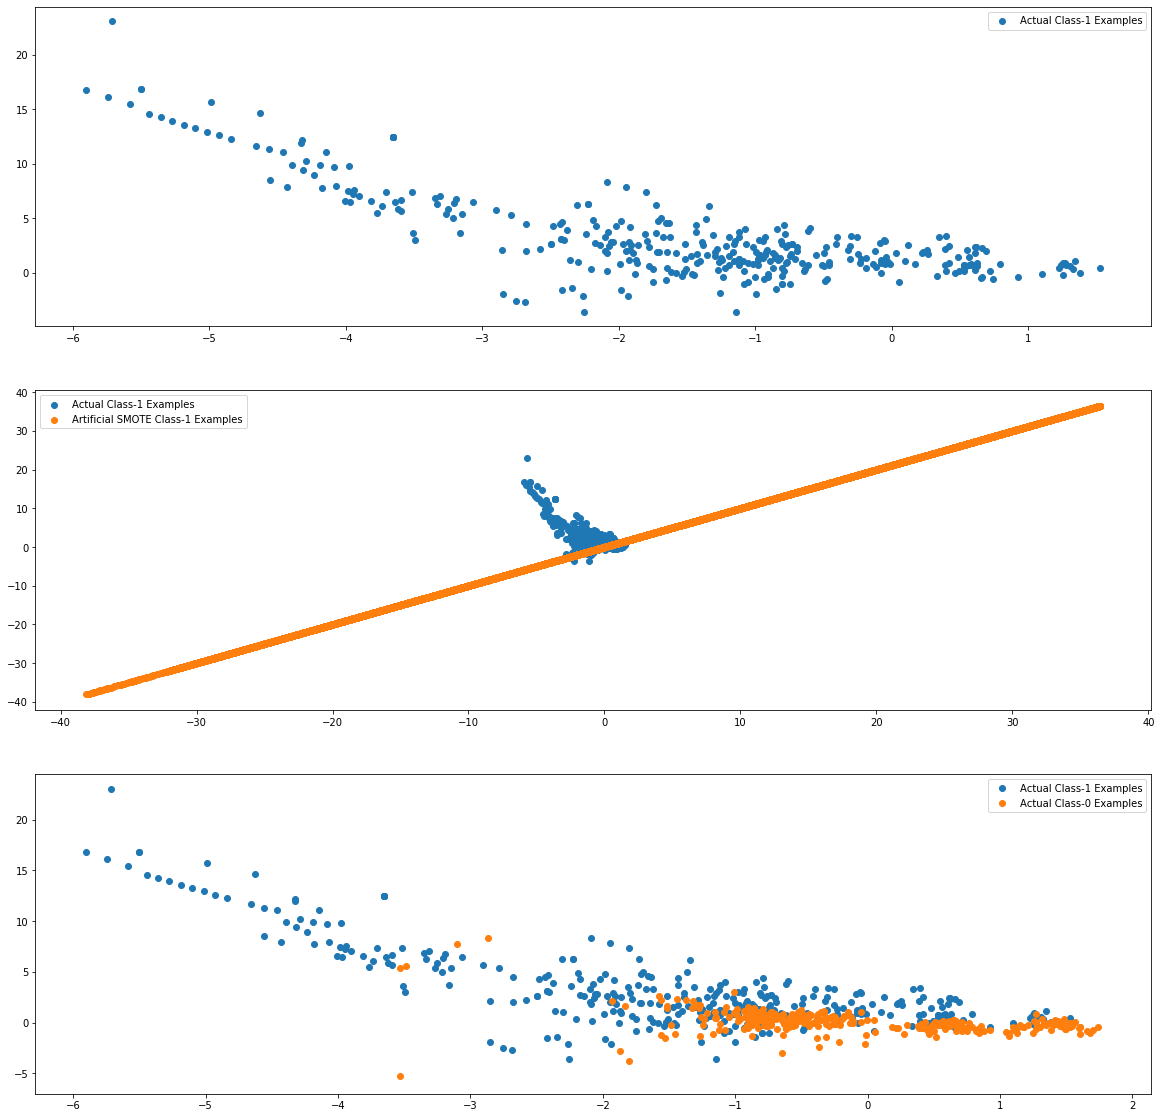

In [51]:
import warnings
warnings.filterwarnings("ignore")

sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:], X_train_smote_1[:],label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

## Model Building

##### Build models on other algorithms to see the better performing on SMOTE

## Logistic Regression

In [53]:
from sklearn import linear_model #import the package

num_C = np.logspace(0, 4, 10)  #--> list of values
cv_num = 5  #--> list of values
penalty = ['l1', 'l2']
hyperparameters = dict(C=num_C, penalty=penalty)

In [54]:
from sklearn.model_selection import GridSearchCV
logistic = linear_model.LogisticRegression()
logistic_cv=GridSearchCV(logistic, hyperparameters, cv=cv_num,scoring= 'roc_auc',return_train_score=True, verbose=0)
logistic_cv.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             

In [55]:
cv_results = pd.DataFrame(logistic_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.096248,0.023210,0.000000,0.000000,1,l1,"{'C': 1.0, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.400021,0.187282,0.053915,0.004248,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.990663,0.991077,0.990745,...,0.990935,0.000205,1,0.991016,0.990865,0.990971,0.990905,0.991003,0.990952,0.000058
2,0.105376,0.005009,0.000000,0.000000,2.78256,l1,"{'C': 2.7825594022071245, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.297330,0.073016,0.052512,0.003763,2.78256,l2,"{'C': 2.7825594022071245, 'penalty': 'l2'}",0.990662,0.991077,0.990745,...,0.990934,0.000205,2,0.991016,0.990865,0.990971,0.990905,0.991003,0.990952,0.000058
4,0.108576,0.008501,0.000000,0.000000,7.74264,l1,"{'C': 7.742636826811269, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# Best Parameters
grid_search(logistic_cv)

Best Estomators = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Params = {'C': 1.0, 'penalty': 'l2'}
Best No of CrossValidation sets = 5
Best Score = 0.9909347005638038


In [57]:
from sklearn.calibration import CalibratedClassifierCV
log_reg_grid_results, trained_model =  model_metrics(logistic_cv, X_train_smote, y_train_smote, X_test, y_test, class_labels=y_train_smote.values)

F1 Score =  0.973970951394497
Accuracy =  0.973970951394497
Recall =  0.8943661971830986
ROC =  0.9730118911143324
Classification report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85301
           1       0.05      0.89      0.10       142

    accuracy                           0.97     85443
   macro avg       0.53      0.93      0.54     85443
weighted avg       1.00      0.97      0.99     85443

Confusion_matrix
[[83092  2209]
 [   15   127]]


In [58]:
#Calibrate the model

sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train_smote, y_train_smote)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0,
                                                         class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='auto',
                                                         n_jobs=None,
                                                         penalty='l2',
                                                         random_state=None,
                                                         solver='lbfgs',
                                                         tol=0.0001, verbose=0,
                                              

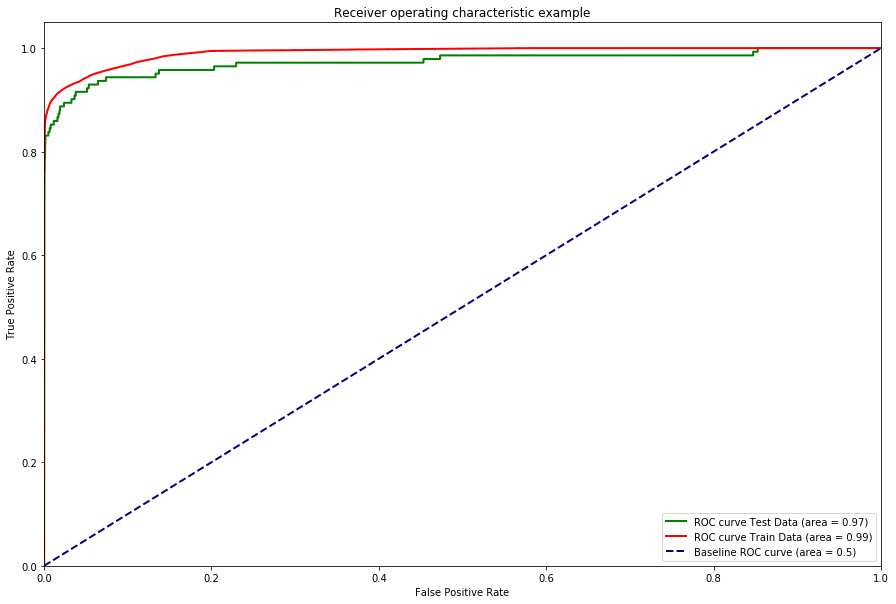

In [59]:
#ROC curve
roc_curve_auc(sig_clf, X_train_smote, y_train_smote, X_test, y_test)

## DecisionTree

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

grid_params = {'max_depth': np.arange(1,10,1),
                    'criterion': ['gini'],
                    'min_samples_split': np.arange(1000,10000,1000),
                    'min_samples_leaf' : np.arange(1000,10000,1000),
                    'min_weight_fraction_leaf' : [0.0,0.1,0.2,0.3,0.4],
                    'max_features': ['auto','sqrt']} 

dtree = DecisionTreeClassifier(random_state=state)
dtree_cv = GridSearchCV(dtree,
                        grid_params,
                        cv=3, scoring='roc_auc',
                        verbose=5,
                        n_jobs=-1,)

dtree_cv.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 7290 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 4600 tasks      | ela

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=48,
                                              splitter='best'),
             iid='depr...
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                        

In [61]:
cv_results = pd.DataFrame(dtree_cv.cv_results_)
cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_min_weight_fraction_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.371991,0.010272,0.190557,0.002266,gini,1,auto,1000,1000,0,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.88444,0.881139,0.88383,0.883136,0.001434,3889
1,1.167257,0.125038,0.167761,0.024295,gini,1,auto,1000,1000,0.1,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.88444,0.881139,0.88383,0.883136,0.001434,3889
2,1.066206,0.013104,0.151482,0.004166,gini,1,auto,1000,1000,0.2,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.88444,0.881139,0.88383,0.883136,0.001434,3889
3,1.030127,0.010558,0.151234,0.007531,gini,1,auto,1000,1000,0.3,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.88444,0.881139,0.88383,0.883136,0.001434,3889
4,1.060477,0.030981,0.146427,0.003964,gini,1,auto,1000,1000,0.4,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.88444,0.881139,0.88383,0.883136,0.001434,3889


In [62]:
log_reg_grid_results, trained_model_dtree =  model_metrics(dtree_cv, X_train_smote, y_train_smote, X_test, y_test, class_labels=y_train_smote.values)

F1 Score =  0.9653219105134417
Accuracy =  0.9653219105134417
Recall =  0.852112676056338
ROC =  0.9613300605263448
Classification report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85301
           1       0.04      0.85      0.08       142

    accuracy                           0.97     85443
   macro avg       0.52      0.91      0.53     85443
weighted avg       1.00      0.97      0.98     85443

Confusion_matrix
[[82359  2942]
 [   21   121]]


In [63]:
#Calibrate the model

sig_clf_dtree = CalibratedClassifierCV(trained_model_dtree, method="sigmoid")
sig_clf_dtree.fit(X_train_smote, y_train_smote)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=9,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1000,
                                                             min_samples_split=1000,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
          

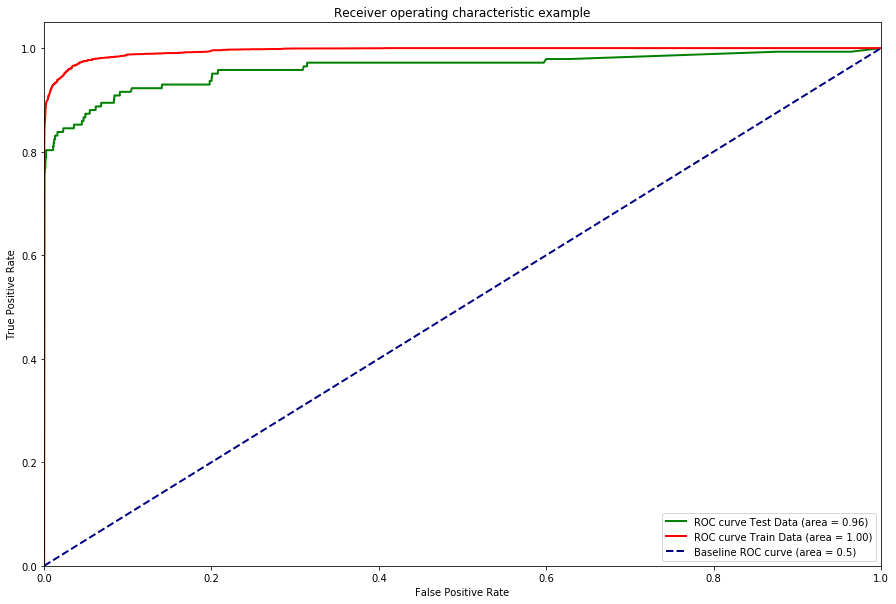

In [64]:
#ROC curve
roc_curve_auc(sig_clf_dtree, X_train_smote, y_train_smote, X_test, y_test)

## Randomforest

In [65]:
from sklearn.ensemble import RandomForestClassifier

grid_params = {
               'max_depth':[8],
               'criterion':['entropy'],
               'max_features':['auto'],
               'min_samples_leaf':[10,20,30],
               'n_estimators':[20,30],
               'max_leaf_nodes':[None, 10,20]}

rfc = RandomForestClassifier(random_state=5)
rfc_cv = GridSearchCV(rfc,
                      grid_params, 
                      cv=3, scoring='roc_auc',
                      verbose=5,
                      n_jobs=-1)

rfc_cv.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 14.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=5,
                                   

In [66]:
cv_results = pd.DataFrame(rfc_cv.cv_results_)
cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,60.001038,0.237036,0.596739,0.009716,entropy,8,auto,None,10,20,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.998886,0.999034,0.999125,0.999015,0.000099,4
1,92.362859,0.475468,0.860701,0.035412,entropy,8,auto,None,10,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.999180,0.999204,0.999104,0.999162,0.000043,1
2,61.282220,1.218991,0.617018,0.045554,entropy,8,auto,None,20,20,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.998853,0.999071,0.998946,0.998957,0.000090,6
3,94.952612,0.138958,0.872669,0.066111,entropy,8,auto,None,20,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.998865,0.999118,0.999044,0.999009,0.000106,5
4,61.495437,2.462402,0.557178,0.013731,entropy,8,auto,None,30,20,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.998944,0.999078,0.999123,0.999049,0.000076,2


In [67]:
# Best Parameters
grid_search(rfc_cv)

Best Estomators = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)
Best Params = {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'n_estimators': 30}
Best No of CrossValidation sets = 3
Best Score = 0.9991622855839225


In [68]:
log_reg_grid_results, trained_model_rfc =  model_metrics(rfc_cv, X_train_smote, y_train_smote, X_test, y_test, class_labels=y_train_smote.values)

F1 Score =  0.9974368877497279
Accuracy =  0.9974368877497279
Recall =  0.8169014084507042
ROC =  0.9757891318084708
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.38      0.82      0.51       142

    accuracy                           1.00     85443
   macro avg       0.69      0.91      0.76     85443
weighted avg       1.00      1.00      1.00     85443

Confusion_matrix
[[85108   193]
 [   26   116]]


In [69]:
#Calibrate the model

sig_clf_rfc = CalibratedClassifierCV(trained_model_rfc, method="sigmoid")
sig_clf_rfc.fit(X_train_smote, y_train_smote)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='entropy',
                                                             max_depth=8,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=10,
                                                             min_samples_split=2,
                              

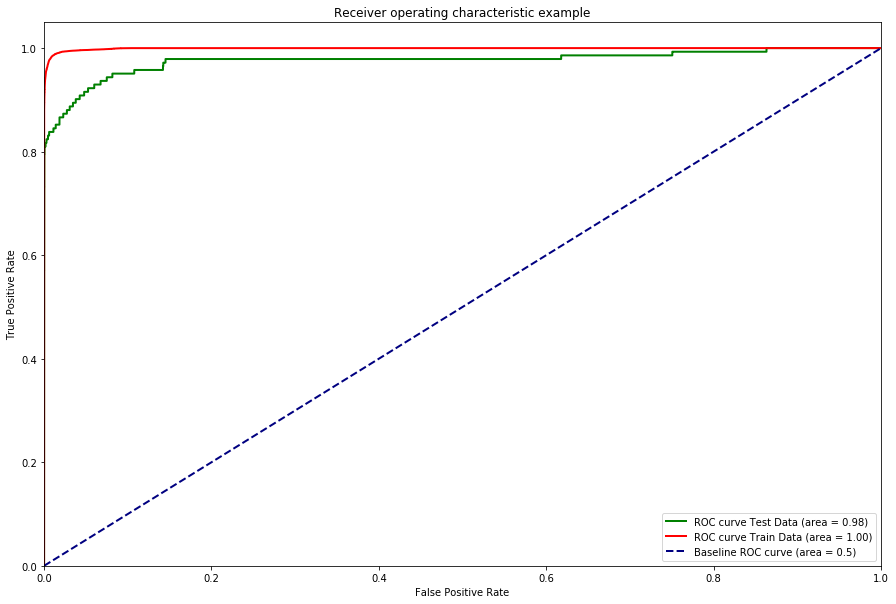

In [70]:
#ROC curve
roc_curve_auc(sig_clf_rfc, X_train_smote, y_train_smote, X_test, y_test)

## RandomForest

In [71]:
import xgboost
from xgboost import XGBClassifier

grid_params =  {'learning_rate':[0.1,0.01],
                    'n_estimators':[25,30],
                    'subsample':[0.6,0.8],
                    'max_depth': [11,15,20],
                    'colsample_bytree':[0.6,0.8],
                    'gamma':[0.25,0.7]}

XGB = XGBClassifier(random_state=state)

XGB_cv = GridSearchCV(XGB,grid_params,
                      cv=3, scoring='roc_auc',
                      
                      verbose=5,
                      n_jobs=-1)
XGB_cv.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 91.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 186.8min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 193.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             

In [72]:

cv_results = pd.DataFrame(XGB_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,98.886675,0.864298,0.779252,0.059565,0.6,0.25,0.1,11,25,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.999870,0.999944,0.999899,0.999904,0.000030,79
1,105.891540,1.840994,0.815488,0.023843,0.6,0.25,0.1,11,25,0.8,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.999870,0.999946,0.999899,0.999905,0.000031,75
2,111.015301,1.152721,0.889623,0.011995,0.6,0.25,0.1,11,30,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.999872,0.999948,0.999902,0.999907,0.000031,72
3,124.193734,1.100393,0.902920,0.028213,0.6,0.25,0.1,11,30,0.8,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.999874,0.999949,0.999901,0.999908,0.000031,66
4,116.175831,0.565022,0.853386,0.035423,0.6,0.25,0.1,15,25,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.999888,0.999954,0.999911,0.999918,0.000028,20


In [73]:
# Best Parameters
grid_search(XGB_cv)


Best Estomators = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=48, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best Params = {'colsample_bytree': 0.6, 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 30, 'subsample': 0.6}
Best No of CrossValidation sets = 3
Best Score = 0.999919053510005


In [74]:
log_reg_grid_results, trained_model_XGB =  model_metrics(XGB_cv, X_train_smote, y_train_smote, X_test, y_test, class_labels=y_train_smote.values)

F1 Score =  0.9989583699074237
Accuracy =  0.9989583699074237
Recall =  0.823943661971831
ROC =  0.975769648193613
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.65      0.82      0.72       142

    accuracy                           1.00     85443
   macro avg       0.82      0.91      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Confusion_matrix
[[85237    64]
 [   25   117]]


In [75]:
#Calibrate the model

sig_clf_XGB = CalibratedClassifierCV(trained_model_XGB, method="sigmoid")
sig_clf_XGB.fit(X_train_smote, y_train_smote)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.6,
                                                    gamma=0.25, gpu_id=-1,
                                                    importance_type='gain',
                                                    interaction_constraints='',
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=20,
                                                    min_child_weight=1,
                                                    missing=nan,
                                                    monotone_constra

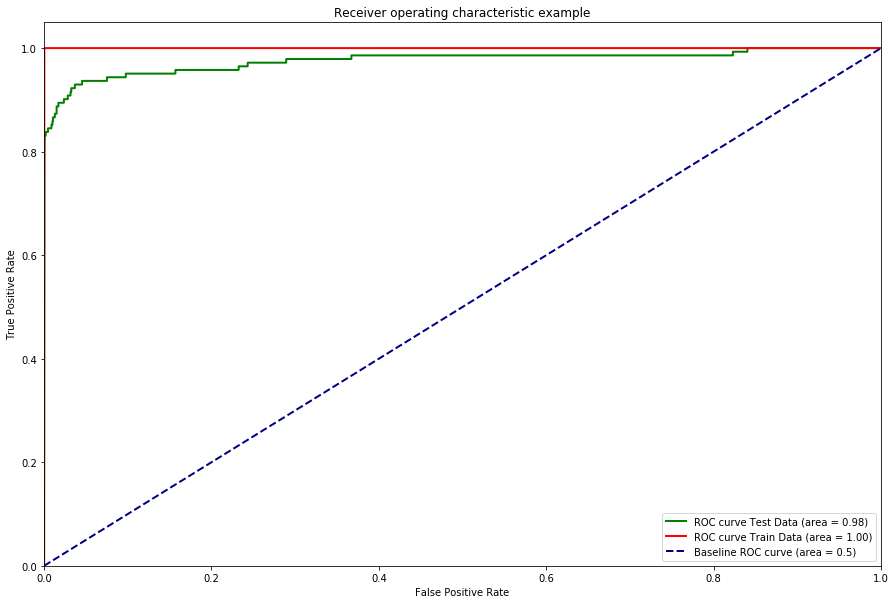

In [76]:
#ROC curve
roc_curve_auc(sig_clf_XGB, X_train_smote, y_train_smote, X_test, y_test)

### Print the class distribution after applying ADASYN

Using TensorFlow backend.


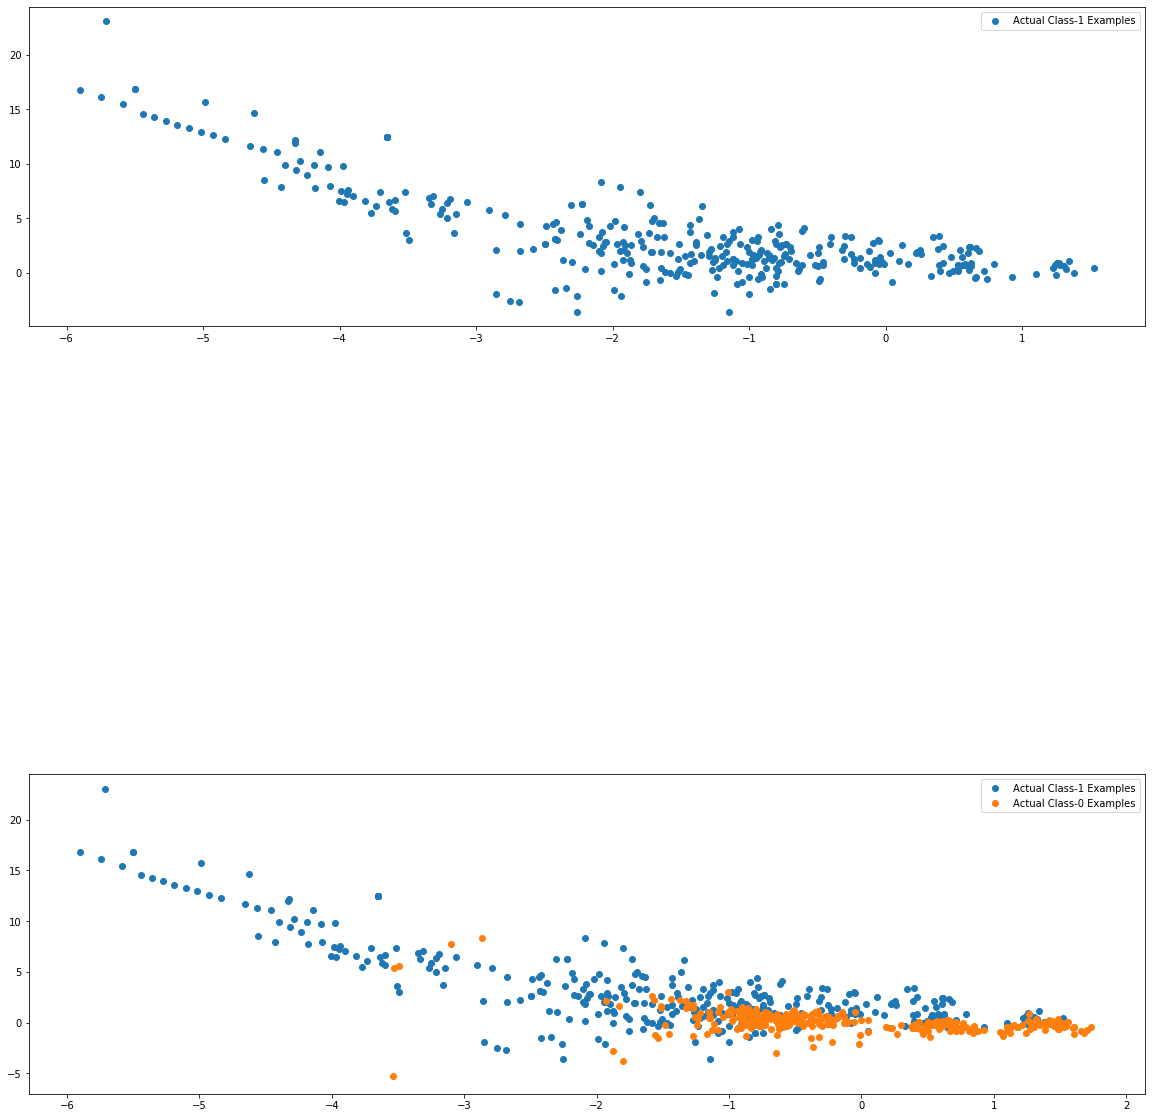

In [13]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()


plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()


## Linear Regression

In [28]:
from sklearn import linear_model #import the package

num_C = np.logspace(0, 4, 10)  #--> list of values
cv_num = 5  #--> list of values
penalty = ['l1', 'l2']
hyperparameters = dict(C=num_C, penalty=penalty)

In [29]:
from sklearn.model_selection import GridSearchCV
logistic = linear_model.LogisticRegression()
logistic_cv=GridSearchCV(logistic, hyperparameters, cv=cv_num,scoring= 'roc_auc',return_train_score=True, verbose=0)
logistic_cv.fit(X_train_adasyn, y_train_adasyn)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             

In [30]:
cv_results = pd.DataFrame(logistic_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.128857,0.022659,0.000000,0.000000,1,l1,"{'C': 1.0, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.544627,0.218748,0.069416,0.012289,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.957321,0.957914,0.934103,...,0.951577,0.009533,1,0.965791,0.967449,0.969388,0.967169,0.967333,0.967426,0.001149
2,0.094183,0.004429,0.000000,0.000000,2.78256,l1,"{'C': 2.7825594022071245, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.531262,0.235241,0.059243,0.004213,2.78256,l2,"{'C': 2.7825594022071245, 'penalty': 'l2'}",0.957321,0.957920,0.934086,...,0.951574,0.009540,2,0.965790,0.967449,0.969388,0.967169,0.967333,0.967426,0.001149
4,0.093766,0.005976,0.000000,0.000000,7.74264,l1,"{'C': 7.742636826811269, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Best Parameters
grid_search(logistic_cv)

Best Estomators = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Params = {'C': 1.0, 'penalty': 'l2'}
Best No of CrossValidation sets = 5
Best Score = 0.9515769068118967


In [34]:
from sklearn.calibration import CalibratedClassifierCV
log_reg_grid_results, trained_model =  model_metrics(logistic_cv, X_train_adasyn, y_train_adasyn, X_test, y_test, class_labels=y_train_adasyn.values)

F1 Score =  0.9077045515723933
Accuracy =  0.9077045515723933
Recall =  0.9436619718309859
ROC =  0.970278653669004
Classification report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     85301
           1       0.02      0.94      0.03       142

    accuracy                           0.91     85443
   macro avg       0.51      0.93      0.49     85443
weighted avg       1.00      0.91      0.95     85443

Confusion_matrix
[[77423  7878]
 [    8   134]]


In [35]:
#Calibrate the model

sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train_adasyn, y_train_adasyn)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0,
                                                         class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='auto',
                                                         n_jobs=None,
                                                         penalty='l2',
                                                         random_state=None,
                                                         solver='lbfgs',
                                                         tol=0.0001, verbose=0,
                                              

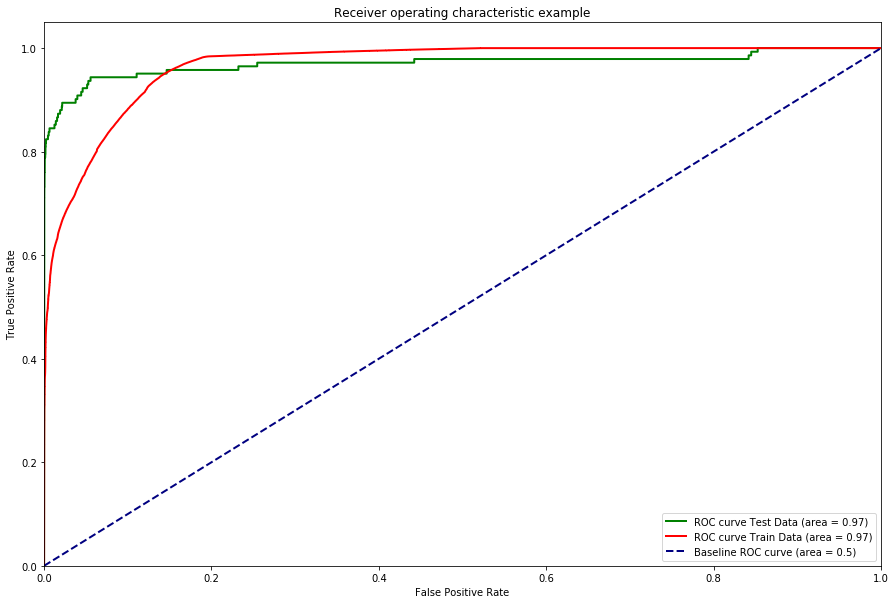

In [36]:
#ROC curve
roc_curve_auc(sig_clf, X_train_adasyn, y_train_adasyn, X_test, y_test)

## DecisionTree

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

grid_params = {'max_depth': np.arange(1,10,1),
                    'criterion': ['gini'],
                    'min_samples_split': np.arange(1000,10000,1000),
                    'min_samples_leaf' : np.arange(1000,10000,1000),
                    'min_weight_fraction_leaf' : [0.0,0.1,0.2,0.3,0.4],
                    'max_features': ['auto','sqrt']} 

dtree = DecisionTreeClassifier(random_state=state)
dtree_cv = GridSearchCV(dtree,
                        grid_params,
                        cv=3, scoring='roc_auc',
                        verbose=5,
                        n_jobs=-1,)

dtree_cv.fit(X_train_adasyn, y_train_adasyn)

Fitting 3 folds for each of 7290 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=48,
                                              splitter='best'),
             iid='depr...
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                        

In [38]:
cv_results = pd.DataFrame(dtree_cv.cv_results_)
cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_min_weight_fraction_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.686840,0.099348,0.262302,0.034094,gini,1,auto,1000,1000,0,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.798022,0.748652,0.737387,0.761354,0.026333,6643
1,1.719424,0.119842,0.278922,0.033424,gini,1,auto,1000,1000,0.1,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.798022,0.748652,0.737387,0.761354,0.026333,6643
2,1.815167,0.344063,0.279924,0.062868,gini,1,auto,1000,1000,0.2,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.798022,0.748652,0.737387,0.761354,0.026333,6643
3,1.362038,0.022483,0.188499,0.013030,gini,1,auto,1000,1000,0.3,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.798022,0.748652,0.737387,0.761354,0.026333,6643
4,1.739696,0.053491,0.199137,0.055280,gini,1,auto,1000,1000,0.4,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.799462,0.748630,0.780948,0.776347,0.021006,5185


In [39]:
log_reg_grid_results, trained_model_dtree =  model_metrics(dtree_cv, X_train_adasyn, y_train_adasyn, X_test, y_test, class_labels=y_train_adasyn.values)

F1 Score =  0.9199466310873916
Accuracy =  0.9199466310873916
Recall =  0.852112676056338
ROC =  0.9694145636058293
Classification report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     85301
           1       0.02      0.85      0.03       142

    accuracy                           0.92     85443
   macro avg       0.51      0.89      0.50     85443
weighted avg       1.00      0.92      0.96     85443

Confusion_matrix
[[78482  6819]
 [   21   121]]


In [40]:
#Calibrate the model

sig_clf_dtree = CalibratedClassifierCV(trained_model_dtree, method="sigmoid")
sig_clf_dtree.fit(X_train_adasyn, y_train_adasyn)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=7,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1000,
                                                             min_samples_split=1000,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
          

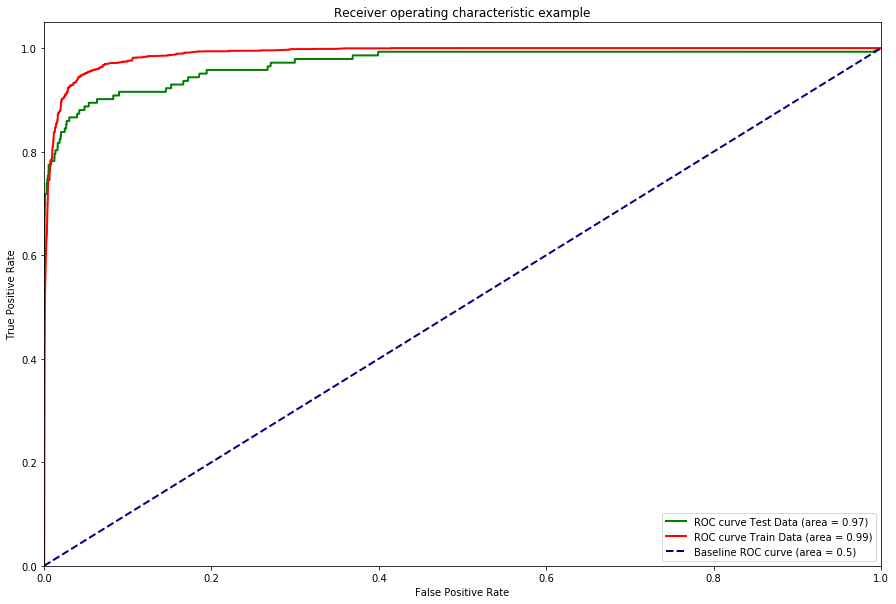

In [41]:
#ROC curve
roc_curve_auc(sig_clf_dtree, X_train_adasyn, y_train_adasyn, X_test, y_test)

## Randomforest

In [42]:
from sklearn.ensemble import RandomForestClassifier

grid_params = {
               'max_depth':[8],
               'criterion':['entropy'],
               'max_features':['auto'],
               'min_samples_leaf':[10,20,30],
               'n_estimators':[20,30],
               'max_leaf_nodes':[None, 10,20]}

rfc = RandomForestClassifier(random_state=5)
rfc_cv = GridSearchCV(rfc,
                      grid_params, 
                      cv=3, scoring='roc_auc',
                      verbose=5,
                      n_jobs=-1)

rfc_cv.fit(X_train_adasyn, y_train_adasyn)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  54 | elapsed: 10.5min remaining:   50.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 11.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=5,
                                   

In [43]:
cv_results = pd.DataFrame(rfc_cv.cv_results_)
cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,92.994725,6.323470,0.939773,0.091814,entropy,8,auto,None,10,20,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.979079,0.985109,0.976501,0.980230,0.003607,2
1,146.157413,12.307998,1.330113,0.160844,entropy,8,auto,None,10,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.982369,0.985610,0.977927,0.981969,0.003150,1
2,91.343831,10.088632,0.823116,0.047374,entropy,8,auto,None,20,20,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.978795,0.980440,0.974007,0.977747,0.002729,6
3,131.626028,11.597260,1.273088,0.191243,entropy,8,auto,None,20,30,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.979541,0.983327,0.976787,0.979885,0.002681,3
4,93.120560,7.456571,0.882441,0.014802,entropy,8,auto,None,30,20,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.980312,0.981022,0.973477,0.978270,0.003402,5


In [44]:
# Best Parameters
grid_search(rfc_cv)

Best Estomators = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)
Best Params = {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'n_estimators': 30}
Best No of CrossValidation sets = 3
Best Score = 0.9819688233533977


In [45]:
log_reg_grid_results, trained_model_rfc =  model_metrics(rfc_cv, X_train_adasyn, y_train_adasyn, X_test, y_test, class_labels=y_train_adasyn.values)

F1 Score =  0.9784768793230575
Accuracy =  0.9784768793230575
Recall =  0.8732394366197183
ROC =  0.9727420100254758
Classification report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85301
           1       0.06      0.87      0.12       142

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

Confusion_matrix
[[83480  1821]
 [   18   124]]


In [46]:
#Calibrate the model

sig_clf_rfc = CalibratedClassifierCV(trained_model_rfc, method="sigmoid")
sig_clf_rfc.fit(X_train_adasyn, y_train_adasyn)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='entropy',
                                                             max_depth=8,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=10,
                                                             min_samples_split=2,
                              

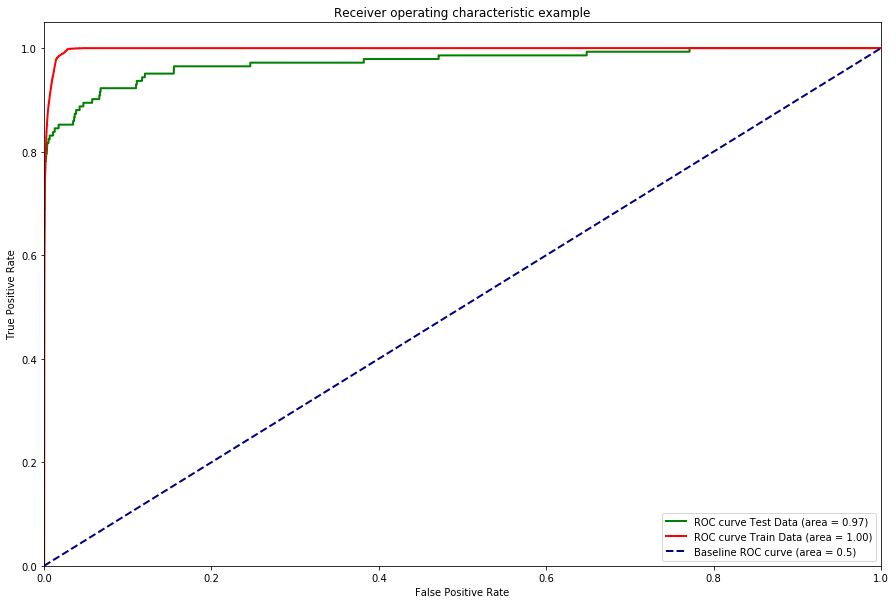

In [47]:
#ROC curve
roc_curve_auc(sig_clf_rfc, X_train_adasyn, y_train_adasyn, X_test, y_test)

## XG Boost

In [48]:
import xgboost
from xgboost import XGBClassifier

grid_params =  {'learning_rate':[0.1,0.01],
                    'n_estimators':[25,30],
                    'subsample':[0.6,0.8],
                    'max_depth': [11,15,20],
                    'colsample_bytree':[0.6,0.8],
                    'gamma':[0.25,0.7]}

XGB = XGBClassifier(random_state=state)

XGB_cv = GridSearchCV(XGB,grid_params,
                      cv=3, scoring='roc_auc',
                      
                      verbose=5,
                      n_jobs=-1)
XGB_cv.fit(X_train_adasyn, y_train_adasyn)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 68.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 143.4min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 153.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             

In [49]:

cv_results = pd.DataFrame(XGB_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,156.453741,15.732525,1.610514,0.202363,0.6,0.25,0.1,11,25,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.978035,0.994642,0.985011,0.985896,0.006809,68
1,161.743177,17.822959,1.262996,0.052978,0.6,0.25,0.1,11,25,0.8,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.979456,0.992785,0.983317,0.985186,0.005600,75
2,171.938887,18.331189,1.408292,0.132220,0.6,0.25,0.1,11,30,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.983105,0.994897,0.986327,0.988110,0.004977,38
3,178.082599,1.140308,1.352448,0.033861,0.6,0.25,0.1,11,30,0.8,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.983089,0.993953,0.984655,0.987232,0.004795,46
4,207.968153,1.358334,1.526328,0.074211,0.6,0.25,0.1,15,25,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.25, 'lear...",0.982098,0.988563,0.991726,0.987462,0.004007,44


In [50]:
# Best Parameters
grid_search(XGB_cv)


Best Estomators = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.7, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=48, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best Params = {'colsample_bytree': 0.6, 'gamma': 0.7, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 30, 'subsample': 0.8}
Best No of CrossValidation sets = 3
Best Score = 0.9925773887316122


In [51]:
log_reg_grid_results, trained_model_XGB =  model_metrics(XGB_cv, X_train_adasyn, y_train_adasyn, X_test, y_test, class_labels=y_train_adasyn.values)

F1 Score =  0.9985955549313578
Accuracy =  0.9985955549313578
Recall =  0.8098591549295775
ROC =  0.971278509853508
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.55      0.81      0.66       142

    accuracy                           1.00     85443
   macro avg       0.78      0.90      0.83     85443
weighted avg       1.00      1.00      1.00     85443

Confusion_matrix
[[85208    93]
 [   27   115]]


In [52]:
#Calibrate the model

sig_clf_XGB = CalibratedClassifierCV(trained_model_XGB, method="sigmoid")
sig_clf_XGB.fit(X_train_adasyn, y_train_adasyn)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.6,
                                                    gamma=0.7, gpu_id=-1,
                                                    importance_type='gain',
                                                    interaction_constraints='',
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=20,
                                                    min_child_weight=1,
                                                    missing=nan,
                                                    monotone_constrai

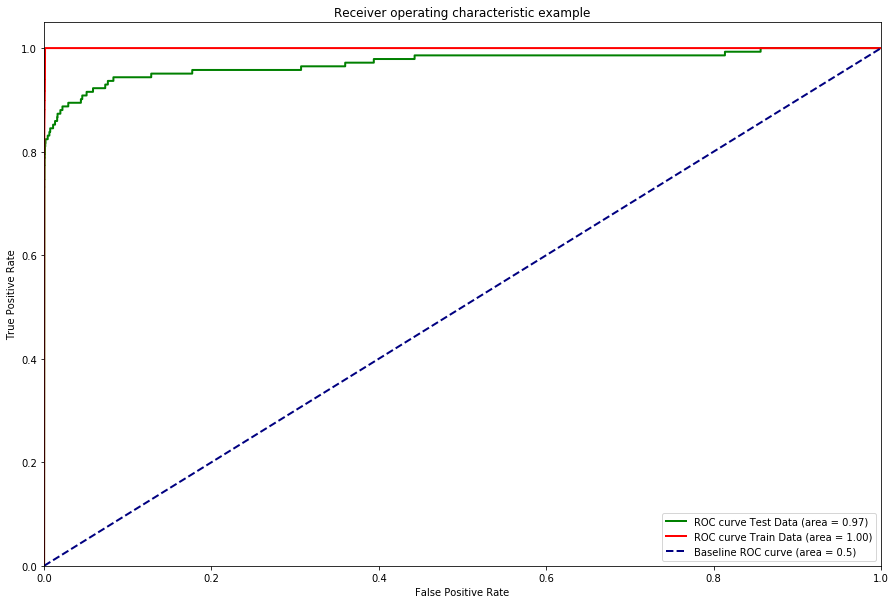

In [53]:
#ROC curve
roc_curve_auc(sig_clf_XGB, X_train_adasyn, y_train_adasyn, X_test, y_test)

### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [43]:
# perform the best oversampling method on X_train & y_train

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)  #initialise the model with optimum hyperparameters
clf.fit(X_train_adasyn, y_train_adasyn)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [48]:
y_predicted_adasyn=clf.predict(X_test)

In [49]:
cm_adasyn=metrics.confusion_matrix(y_test,y_predicted_adasyn)

In [50]:
cm_adasyn

array([[83480,  1821],
       [   18,   124]], dtype=int64)

In [53]:
# Going by Recall as final metric
recall=cm_adasyn[1][1]/(cm_adasyn[1][1]+cm_adasyn[1][0])
recall

0.8732394366197183

### Print the important features of the best model to understand the dataset

Top var = 4
2nd Top var = 14
3rd Top var = 17


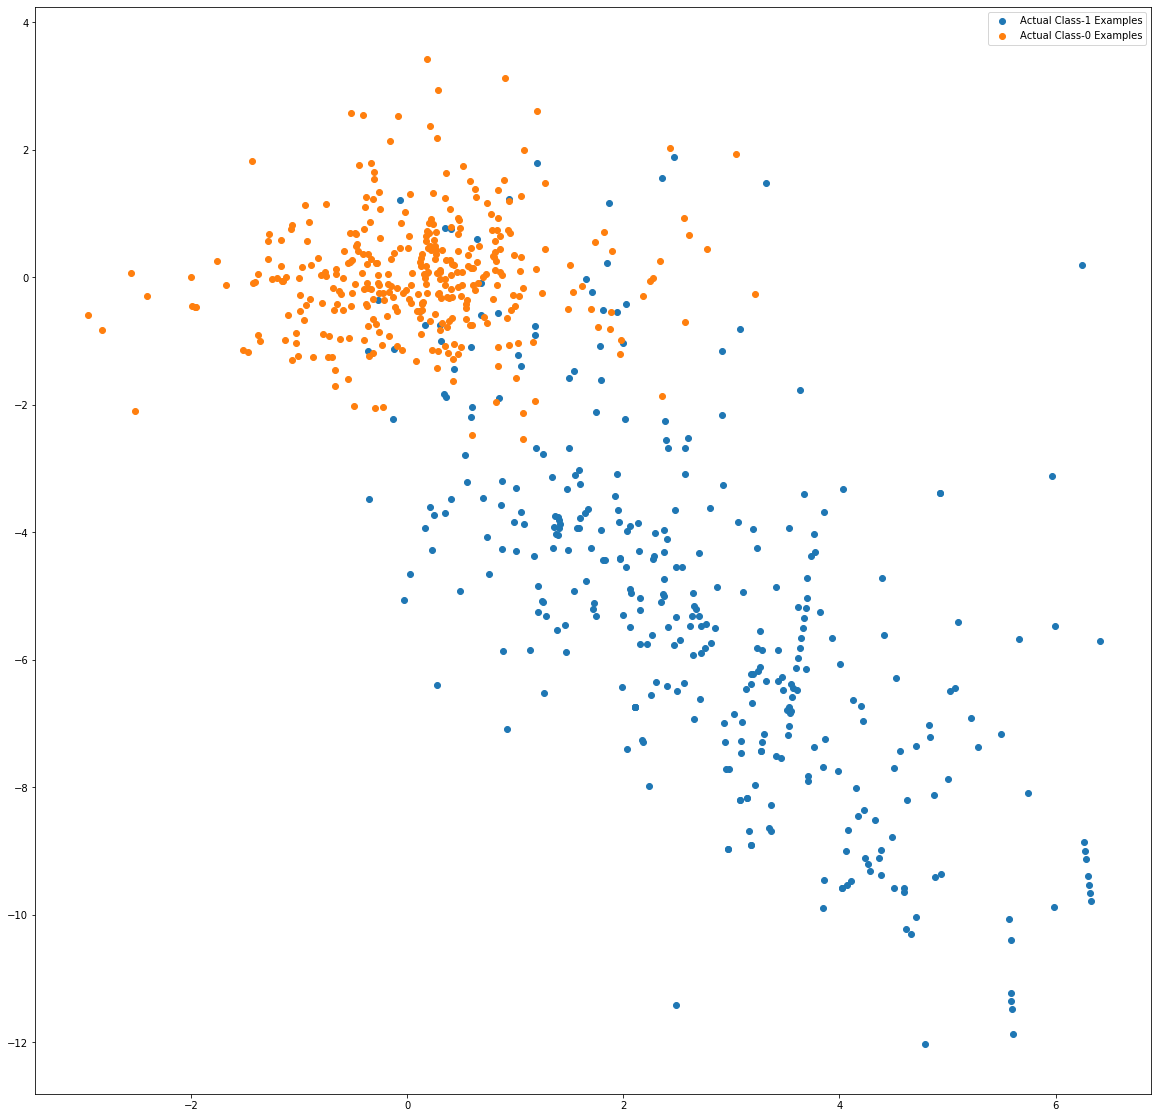

In [15]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()